### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pennylane import numpy as np
from pennylane.templates import BasicEntanglerLayers,StronglyEntanglingLayers,RandomLayers
from pennylane import broadcast
import h5py
import pennylane as qml
import deap
import random
import time
import multiprocessing as mp
import itertools
# from itertools import combinations
qml.__version__

'0.24.0'

### File Reading 

In [2]:
jet_filename = '../jetImage_0_30p_0_10000.h5'
f1 = h5py.File(jet_filename,'r')
jets = np.array(f1["jets"])

In [3]:
j_pt = jets[:, 1]
j_eta = jets[:, 2]
j_mass = jets[:, 3]

In [4]:
num_bins = 16

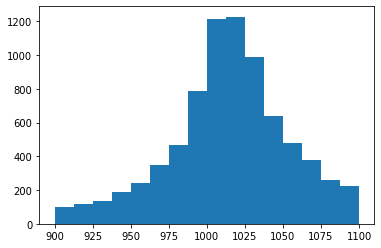

In [5]:
min_pt = 900
max_pt = 1100
distribution_pt, bins_pt_edge, __ = plt.hist(j_pt, range=[min_pt, max_pt], bins=num_bins)
probability_pt = distribution_pt / np.sum(distribution_pt)
bins_pt = np.asarray([(bins_pt_edge[i] + bins_pt_edge[i+1])/2. for i in range(len(bins_pt_edge)-1)])

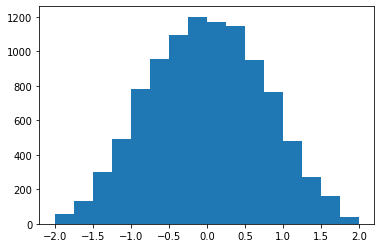

In [6]:
min_eta = -2
max_eta = 2
distribution_eta, bins_eta_edge, __ =plt.hist(j_eta, range=[min_eta, max_eta], bins=num_bins)
probability_eta = distribution_eta / np.sum(distribution_eta)
bins_eta = np.asarray([(bins_eta_edge[i] + bins_eta_edge[i+1])/2. for i in range(len(bins_eta_edge)-1)])

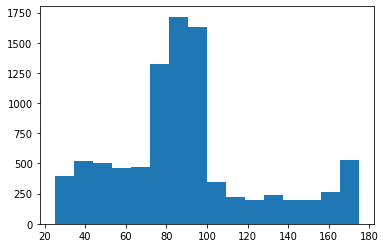

In [7]:
min_mass = 25
max_mass = 175
distribution_mass, bins_mass_edge, __ =plt.hist(j_mass, range=[min_mass, max_mass],bins=num_bins)
probability_mass = distribution_mass / np.sum(distribution_mass)
bins_mass = np.asarray([(bins_mass_edge[i] + bins_mass_edge[i+1])/2. for i in range(len(bins_mass_edge)-1)])

### Tensor Encoding

In [8]:
n_qubits = 4

In [9]:
dev_wires = [np.array(idx, requires_grad=True) for idx in range(n_qubits)]
dev = qml.device('qulacs.simulator', wires=dev_wires, gpu=True, shots=10000)

In [10]:
### keys represent gates, values represent number of parameters required
two_qubits_gates_with_params = {qml.CNOT:0}
one_qubit_gates_with_params = {qml.RX:1, qml.RY:1, qml.RZ:1}
two_qubits_gates = list(two_qubits_gates_with_params.keys())
one_qubit_gates = list(one_qubit_gates_with_params.keys())

Format of the tensor: \
[MOMENT1, MOMENT2,....] \
Within each moment: an n_qubits by (1 + # one qubit gates + 2 * # two qubit gates) matrix \
for one qubit gates, 1 means on and 0 means off \
for two qubit gates, the number means the corresponding target/control qubit to apply the gate to

In [11]:
# def get_num_params(tensor, n_qubits, num_one_gates, num_two_gates):
#     num_params = 0
#     total_gates = num_one_gates + num_two_gates
#     for moment in tensor:
#         for q_idx in range(n_qubits):
#             curr_qubit = moment[q_idx]
#             if not curr_qubit[0]:
#                 for gate_idx in range(1, total_gates+1):
#                     if not curr_qubit[gate_idx]:
#                         if gate_idx <= num_one_gates:
#                             gate = one_qubit_gates[gate_idx-1]
#                             curr_num_params = one_qubit_gates_with_params[gate]
#                             num_params += curr_num_params
#                         else:
#                             gate = two_qubits_gates[gate_idx - num_one_gates - 1]
#                             target_idx = curr_qubit[gate_idx] - 1
#                             curr_num_params = two_qubits_gates_with_params[gate]
#                             num_params += curr_num_params
#                         break
#     return num_params

In [12]:
def get_num_params(tensor, n_qubits, num_one_gates, num_two_gates):
    num_params = 0
    total_gates = num_one_gates + num_two_gates
    for moment in tensor:
        for q_idx in range(n_qubits):
            curr_qubit = moment[q_idx]
            for gate_idx in range(0, total_gates):
                if not curr_qubit[gate_idx]:
                    if gate_idx <= num_one_gates:
                        gate = one_qubit_gates[gate_idx]
                        curr_num_params = one_qubit_gates_with_params[gate]
                        num_params += curr_num_params
                    else:
                        gate = two_qubits_gates[gate_idx - num_one_gates]
                        target_idx = curr_qubit[gate_idx] - 1
                        curr_num_params = two_qubits_gates_with_params[gate]
                        num_params += curr_num_params
                    break
    return num_params

In [13]:
# @qml.qnode(dev)
# def convert_tensor_to_circuit(tensor, params, n_qubits, num_one_gates, num_two_gates, prob=True):
#     total_gates = 1 + num_one_gates + num_two_gates*2
#     params_idx = 0
#     for moment in tensor:
#         for q_idx in range(n_qubits):
#             curr_qubit = moment[q_idx]
#             if not curr_qubit[0]:
#                 for gate_idx in range(1, total_gates):
#                     if not curr_qubit[gate_idx] == 0:
#                         if gate_idx <= num_one_gates:
#                             gate = one_qubit_gates[gate_idx-1]
#                             curr_num_params = one_qubit_gates_with_params[gate]
#                             if curr_num_params == 0:
#                                 gate(wires=dev_wires[q_idx])
#                             else:
#                                 broadcast(unitary=gate, pattern="single", wires=dev_wires[q_idx], parameters=params[params_idx:params_idx+curr_num_params])
#                                 params_idx += curr_num_params
#                         else:
#                             if (gate_idx - num_one_gates) % 2 == 1:
#                                 gate = two_qubits_gates[gate_idx - num_one_gates - 1]
#                                 target_idx = curr_qubit[gate_idx] -1
#                                 curr_num_params = two_qubits_gates_with_params[gate]
#                                 if curr_num_params == 0:
#                                     gate(wires=[dev_wires[q_idx], dev_wires[target_idx]])
#                                 else:
#                                     broadcast(unitary=gate, pattern="double", wires=[dev_wires[q_idx], dev_wires[target_idx]], parameters=params[params_idx:params_idx+curr_num_params])
#                                     params_idx += curr_num_params
#                         break
    
#     if prob:
#         return qml.probs(wires=dev_wires[0:n_qubits])
#     else:
#         return qml.sample(wires=dev_wires[0:n_qubits])

In [14]:
@qml.qnode(dev)
def convert_tensor_to_circuit(tensor, params, n_qubits, num_one_gates, num_two_gates, prob=True):
    total_gates = num_one_gates + num_two_gates*2
    params_idx = 0
    for moment in tensor:
        for q_idx in range(n_qubits):
            curr_qubit = moment[q_idx]
            for gate_idx in range(total_gates):
                if not curr_qubit[gate_idx] == 0:
                    if gate_idx < num_one_gates:
                        gate = one_qubit_gates[gate_idx]
                        curr_num_params = one_qubit_gates_with_params[gate]
                        if curr_num_params == 0:
                            gate(wires=dev_wires[q_idx])
                        else:
                            broadcast(unitary=gate, pattern="single", wires=dev_wires[q_idx], parameters=params[params_idx:params_idx+curr_num_params])
                            params_idx += curr_num_params
                    else:
                        if (gate_idx - num_one_gates) % 2 == 0:
                            gate = two_qubits_gates[gate_idx - num_one_gates]
                            target_idx = curr_qubit[gate_idx] -1
                            curr_num_params = two_qubits_gates_with_params[gate]
                            if curr_num_params == 0:
                                gate(wires=[dev_wires[q_idx], dev_wires[target_idx]])
                            else:
                                broadcast(unitary=gate, pattern="double", wires=[dev_wires[q_idx], dev_wires[target_idx]], parameters=params[params_idx:params_idx+curr_num_params])
                                params_idx += curr_num_params
                    break
    
    if prob:
        return qml.probs(wires=dev_wires[0:n_qubits])
    else:
        return qml.sample(wires=dev_wires[0:n_qubits])

In [15]:
tensor = [[[0, 1, 0, 0, 0], 
           [0, 0, 1, 0, 0], 
           [0, 1, 0, 0, 0], 
           [1, 0, 0, 0, 0],
           [0, 0, 0, 0, 0], 
           [1, 0, 0, 0, 0], 
           [0, 1, 0, 0, 0], 
           [0, 1, 0, 0, 0]]
         ]

num_params = get_num_params(tensor, n_qubits, 3, 1)
init_params = (2.*np.pi)*np.random.random(num_params)


convert_tensor_to_circuit(tensor, init_params, n_qubits, 3, 1).shape

(16,)

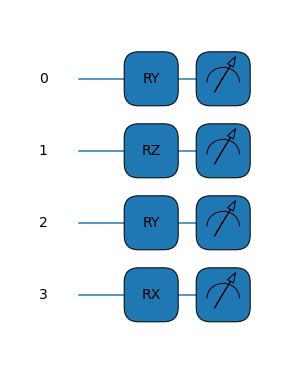

In [16]:
fig, ax = qml.draw_mpl(convert_tensor_to_circuit)(tensor, init_params, n_qubits, 3, 1)
fig.show()

### Random Generation of Tensors (v1)

In [17]:
def generate_random_tensor(n_qubits, num_one_gates, num_two_gates, max_moments):
    tensor = []
    total_gates = num_one_gates + num_two_gates * 2
    num_moments = random.randint(1,max_moments)
    for m in range(num_moments):
        moment = []
        for q in range(n_qubits):
            curr_qubit = [0] * total_gates
            moment.append(curr_qubit)
        qubit_options = list(range(n_qubits))
        gates_options = list(range(total_gates))
        while not len(qubit_options) == 0:
            rand_gates_idx = random.choice(gates_options)
            if rand_gates_idx < num_one_gates:
                rand_qubit_idx = random.choice(qubit_options)
                moment[rand_qubit_idx][rand_gates_idx] = 1
                qubit_options.remove(rand_qubit_idx)
            else:
                if len(qubit_options) >= 2:
                    rand_control, rand_target = random.sample(qubit_options, k = 2)
                    qubits_used = [rand_control, rand_target]
                    # qubits_used = list(range(min(rand_target, rand_control), max(rand_target, rand_control)))
                    if all(x in qubit_options for x in qubits_used):
                        if (rand_gates_idx - num_one_gates) % 2 == 0:
                            moment[rand_control][rand_gates_idx] = rand_target + 1
                            moment[rand_target][rand_gates_idx + 1] = rand_control + 1
                        else:
                            moment[rand_control][rand_gates_idx -1] = rand_target + 1
                            moment[rand_target][rand_gates_idx] = rand_control + 1
                        qubit_options = [ q for q in qubit_options if not q in qubits_used]
                    else:
                        qubit_options.append(rand_control)
        tensor.append(moment)
    return tensor


### Random Generation of Tensors (v2)

In [18]:
# def generate_random_tensor(n_qubits, num_one_gates, num_two_gates, max_moments):
#     tensor = []
#     total_gates = 1 + num_one_gates + num_two_gates * 2
#     num_moments = random.randint(1,max_moments)
#     for m in range(num_moments):
#         moment = []
#         for q in range(n_qubits):
#             curr_qubit = [0] * total_gates
#             moment.append(curr_qubit)
#         qubit_options = list(range(n_qubits))
#         gates_options = list(range(total_gates))
#         while not len(qubit_options) == 0:
#             rand_gates_idx = random.choice(gates_options)
#             if rand_gates_idx <= num_one_gates:
#                 rand_qubit_idx = random.choice(qubit_options)
#                 moment[rand_qubit_idx][rand_gates_idx] = 1
#                 qubit_options.remove(rand_qubit_idx)
#             else:
#                 if len(qubit_options) >= 2:
#                     rand_control, rand_target = random.sample(qubit_options, k = 2)
#                     if (rand_gates_idx - num_one_gates) % 2 == 1:
#                         moment[rand_control][rand_gates_idx] = rand_target + 1
#                         moment[rand_target][rand_gates_idx + 1] = rand_control + 1
#                     else:
#                         moment[rand_control][rand_gates_idx -1] = rand_target + 1
#                         moment[rand_target][rand_gates_idx] = rand_control + 1
#                     qubit_options.remove(rand_control)
#                     qubit_options.remove(rand_target)
                    
#         tensor.append(moment)
#     # print(tensor)
#     return tensor


[[[0, 0, 0, 0, 3], [0, 0, 0, 0, 4], [0, 0, 0, 1, 0], [0, 0, 0, 2, 0]]]
(16,)


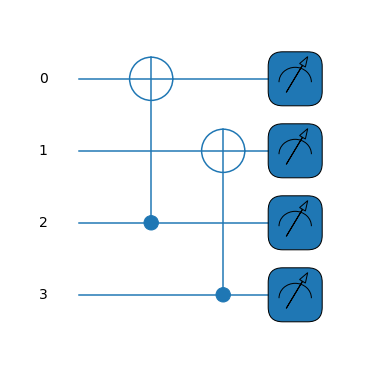

In [19]:
max_moments = 2
tensor = generate_random_tensor(n_qubits, 3 ,1, max_moments)
num_params = get_num_params(tensor, n_qubits, 3, 1)
init_params = (2.*np.pi)*np.random.random(num_params)
print(tensor)
print(convert_tensor_to_circuit(tensor, init_params, n_qubits, 3, 1).shape)
fig, ax = qml.draw_mpl(convert_tensor_to_circuit)(tensor, init_params, n_qubits, 3, 1)
fig.show()

### Testing 

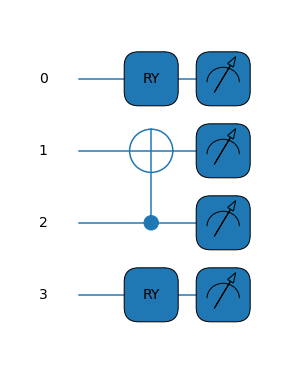

In [20]:
random_tensor = generate_random_tensor(n_qubits, 3 ,1, max_moments)
num_params = get_num_params(random_tensor, n_qubits, 3, 1)
init_params = (2.*np.pi)*np.random.random(num_params)
convert_tensor_to_circuit(random_tensor, init_params, n_qubits, 3, 1)
fig, ax = qml.draw_mpl(convert_tensor_to_circuit)(random_tensor, init_params, n_qubits, 3, 1)
fig.show()

In [21]:
random_tensor

[[[0, 1, 0, 0, 0], [0, 0, 0, 0, 3], [0, 0, 0, 2, 0], [0, 1, 0, 0, 0]]]

In [22]:
# generate 10 random number of circuits
num_circuits = 2
ansatz_space = []
for i in range(num_circuits):
    random_tensor = generate_random_tensor(n_qubits, 3 ,1, max_moments)
    ansatz_space.append(random_tensor)
    num_params = get_num_params(random_tensor, n_qubits, 3, 1)
    init_params = (2.*np.pi)*np.random.random(num_params)
    convert_tensor_to_circuit(random_tensor, init_params, n_qubits, 3, 1)
    # fig, ax = qml.draw_mpl(convert_tensor_to_circuit)(random_tensor, init_params, n_qubits, 3, 1)
    # fig.show()

In [23]:
ansatz_space

[[[[0, 0, 0, 4, 0], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1]],
  [[0, 0, 0, 3, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 1, 0, 0, 0]]],
 [[[0, 0, 0, 0, 3], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0]],
  [[0, 0, 0, 0, 4], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0]]]]

### Tentative Training

In [24]:
### Loss Functions

def qml_entropy(pk,qk):
    '''
    do not use scipy implementatin of entropy, will use different numpy versions
    this uses the pennylane wrapped version of numpy
    '''
    qk = np.asarray(qk)
    ck = np.broadcast(pk, qk)

    vec = [u*np.log(u/v) if (u>0 and v>0) else 0 if (u == 0 and v>=0) else np.inf for (u,v) in ck]
    S = np.sum(vec)
    return S

def hybrid_jensen_shannon_loss(pk,qk):
    ''' this is a temporary function while we debug the layerwise training'''
    p = target
    q = hybrid_pdf(params,fixed_params=fixed_params)
    M = np.multiply(q+p,0.5)

    return 0.5*qml_entropy(p,M)+0.5*qml_entropy(q,M)

def jensen_shannon_loss(p,q):
    M = np.multiply(q+p,0.5)
    return 0.5*qml_entropy(p,M)+0.5*qml_entropy(q,M)


### Stop conditions

def scheduled_stepsize(iteration):
    min_step= 0.000001
    max_step = 0.01
    ss = min_step+(max_step - min_step)*np.abs(np.cos(np.pi/10.*iteration))
    print('step size set to {}'.format(ss))
    return ss

def scheduled_opt(self,iteration, opt_method):
    return opt_method(stepsize=scheduled_stepsize(iteration))


def early_stopping(loss_values ,  patience=1, draw=False):
    #check whether the loss is plateauing
    if len(loss_values) < 2*patience:
        #not enough values to think about
        return False

    ref_value = np.min(loss_values[-2*patience:-patience])
    last_value = np.min( loss_values[-patience:])
    return (last_value >= ref_value)


def adaptLR(losses, opt):
    last_N = 10
    factor = 2
    if len(losses)<last_N: return False
    # if len(losses)-adaptLR.lastchange< last_N: return False
    max_consecutive_downards = np.max([ sum( 1 for _ in group ) for key, group in itertools.groupby( np.diff( losses[-last_N:]) <0  ) if key ])
    roughness = 1.-max_consecutive_downards / float(last_N-1)
    #print(f"Loss roughness: {roughness}")
    if roughness > 0.5:
        # adaptLR.lastchange = len(losses)
        old_LR = np.asarray(opt.stepsize)
        opt.stepsize = old_LR/ factor
        # print(f"Reducing LR :{old_LR} \u2192 {np.asarray(opt.stepsize)}")
        # plt.figure(figsize=(10,3))
        # plt.plot(losses[-last_N:])
        # ymin,ymax = plt.ylim()
        # offset = 0.1* (ymax-ymin)
        # plt.xlabel('last iterations')
        # plt.ylabel('training loss')
        # plt.show()
        return True

In [25]:
class IndividualCircuit:
    
    def __init__(self, tensor, target, num_one_gates, num_two_gates, n_qubits, n_steps=None, scheduled=False):
        self.tensor = tensor
        self.params = (2.*np.pi)*np.random.random(get_num_params(tensor, n_qubits, num_one_gates, num_two_gates))
        self.num_one_gates = num_one_gates
        self.num_two_gates = num_two_gates
        self.fitness = 0.0
        self.losses = []
        self.fitnesses = []
        self.n_qubits = n_qubits
        self.best_loss_idx = 0
        self.target = target
        self.LR = []
        
    def train(self, circuit, n_steps=None, scheduled=False):
        trained_params = self.params.copy()
        start = time.mktime(time.gmtime())
        stop = start
        i_steps = 0
        init_stepsize = 0.01
        opt = qml.AdamOptimizer(stepsize=init_stepsize)
        # self.LR.append(init_stepsize)
        best_params = trained_params
        while True:
            # update the circuit parameters in each iteration
            prelap = time.mktime(time.gmtime())
            iteration = len(self.losses)
            # print('starting iteration {}'.format(len(self.losses)+1))
            if scheduled: 
                opt=scheduled_opt(len(self.losses))
            trained_params, L = opt.step_and_cost(lambda v: self.loss_1d(circuit,v), trained_params)
            lap = start = time.mktime(time.gmtime())
            step_time = lap - prelap
            stop+=step_time
            # L = loss(trained_params) 
            self.losses.append( L )
            
            # if adaptLR(self.losses, opt):
            #     self.LR.append(opt.stepsize)
                
            
            # update the stop conditions
            early_stop  = early_stopping( self.losses, patience=20)
            i_steps+=1
            i_stop = (n_steps!=None) and (i_steps>=n_steps)
            stop = early_stop or i_stop
            
            # keep track of the min loss and corresponding params
            curr_min_idx = np.where(self.losses == np.min(self.losses))[0][-1]
            self.best_loss_idx = curr_min_idx
            if curr_min_idx == iteration - 1: 
                self.best_loss_idx = curr_min_idx
                self.params = trained_params
                
            if stop: break
        
        self.fitnesses = [1 - x for x in self.losses]
        
        
    def adaptLR(self, opt):
        last_N = 10
        factor = 2
        if len(self.losses)<last_N: return False
        if len(self.losses)-self.last_LR_change< last_N: return False
        max_consecutive_downards = np.max([ sum( 1 for _ in group ) for key, group in itertools.groupby( np.diff( self.losses[-last_N:]) <0  ) if key ])
        roughness = 1.-max_consecutive_downards / float(last_N-1)
        print(f"Loss roughness: {roughness}")
        if roughness > 0.5:
            self.last_LR_change = len(losses)
            old_LR = np.asarray(opt.stepsize)
            opt.stepsize = old_LR/ factor
            print(f"Reducing LR :{old_LR} \u2192 {np.asarray(opt.stepsize)}")
            plt.figure(figsize=(10,3))
            plt.plot(losses[-last_N:])
            ymin,ymax = plt.ylim()
            offset = 0.1* (ymax-ymin)
            plt.xlabel('last iterations')
            plt.ylabel('training loss')
            plt.show()
            return True


    def train_fitness(self, n_steps=None, scheduled=False):
        # if self.fitness == 1.0:
        self.train(convert_tensor_to_circuit, n_steps, scheduled)
        self.fitness = self.fitnesses[self.best_loss_idx]
    
    def get_fitness(self):
        return self.fitness
    
    
    def draw(self, title=""):
        fig, ax = qml.draw_mpl(convert_tensor_to_circuit)(self.tensor, self.params, self.n_qubits, self.num_one_gates, self.num_two_gates)
        ax.set_title(title)
        fig.show()
    
    def plot_fitness(self, title="fitnesses"):
        plt.title(title)
        plt.plot(self.fitnesses)
        plt.xlabel('iterations')
        plt.ylabel('fitness')
        plt.scatter(self.best_loss_idx, self.fitnesses[self.best_loss_idx],c='r')
        plt.show()
    
    def plot_loss(self, title="losses"):
        plt.title(title)
        plt.plot(self.losses)
        plt.xlabel('iterations')
        plt.ylabel('training loss')
        plt.scatter(self.best_loss_idx, self.losses[self.best_loss_idx],c='r')
        plt.show()
        
        
    def get_tensor(self):
        return self.tensor        
        
    def loss_1d(self, circuit, params):
        return jensen_shannon_loss(circuit(self.tensor, params, self.n_qubits, self.num_one_gates, self.num_two_gates), self.target)
    
    def loss_2d(self, circuit, params):
        return jensen_shannon_loss(circuit(self.tensor, self.params, self.n_qubits, self.num_one_gates, self.num_two_gates).reshape(16,16),self.target.reshape(16,16))

#### Test Individual Circuit

##### 2D

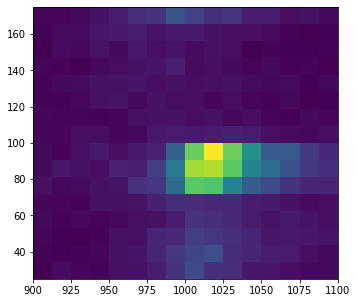

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(121)
target_2d, bins_pt_edge, bins_mass_edge, _ = plt.hist2d(j_pt, j_mass, bins=[16,16], range=[[min_pt, max_pt],[min_mass, max_mass]])
target_2d = target_2d / np.sum(target_2d)
target_1d = np.ravel(target_2d)

In [83]:
target_1d

tensor([0.        , 0.00012863, 0.00025727, 0.0003859 , 0.00141497,
        0.0007718 , 0.00128634, 0.00128634, 0.00154361, 0.00090044,
        0.00167224, 0.00102907, 0.00141497, 0.00051454, 0.00025727,
        0.        , 0.        , 0.00025727, 0.00025727, 0.00090044,
        0.00102907, 0.00167224, 0.00090044, 0.00205814, 0.00180087,
        0.00180087, 0.00218678, 0.00167224, 0.00025727, 0.        ,
        0.00012863, 0.00012863, 0.        , 0.00025727, 0.00090044,
        0.00051454, 0.00180087, 0.00167224, 0.00154361, 0.00244404,
        0.00205814, 0.00270131, 0.00141497, 0.00064317, 0.0007718 ,
        0.00025727, 0.00012863, 0.00012863, 0.00025727, 0.0003859 ,
        0.00090044, 0.00141497, 0.00128634, 0.00218678, 0.00257268,
        0.00295858, 0.00308721, 0.00308721, 0.00154361, 0.00218678,
        0.00064317, 0.00115771, 0.00051454, 0.00012863, 0.00025727,
        0.00051454, 0.00115771, 0.00167224, 0.00231541, 0.00218678,
        0.00475945, 0.00360175, 0.00295858, 0.00

In [39]:
tensor = [[[1, 0, 0, 0, 0],
  [1, 0, 0, 0, 0],
  [1, 0, 0, 0, 0],
  [1, 0, 0, 0, 0],
  [1, 0, 0, 0, 0],
  [1, 0, 0, 0, 0],
  [1, 0, 0, 0, 0],
  [1, 0, 0, 0, 0]],
 [[0, 0, 0, 2, 0],
  [0, 0, 0, 0, 1],
  [0, 0, 0, 4, 0],
  [0, 0, 0, 0, 3],
  [0, 0, 0, 6, 0],
  [0, 0, 0, 0, 5],
  [0, 0, 0, 8, 0],
  [0, 0, 0, 0, 7]]]

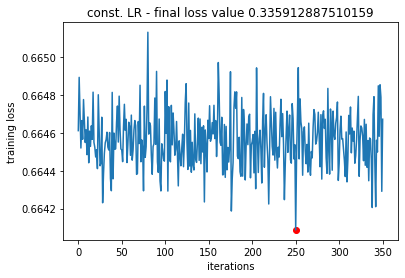

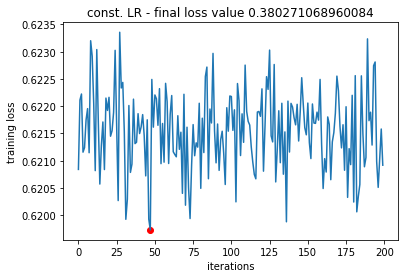

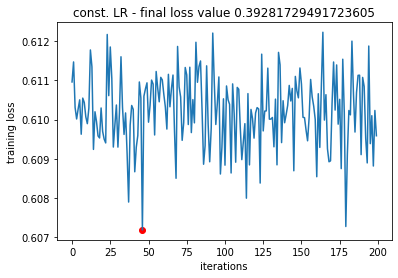

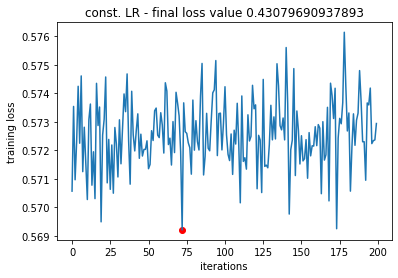

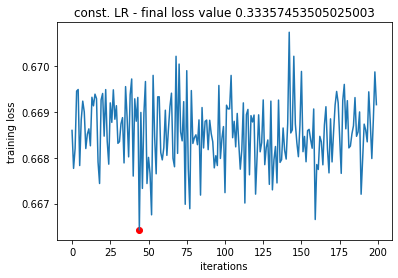

In [36]:
for i in range(5):
    max_moments = 2
    num_one_gates = 3
    num_two_gates = 1
    tensor = generate_random_tensor(8, num_one_gates , num_two_gates, max_moments)

    # convert_tensor_to_circuit(tensor, init_params, n_qubits, num_one_gates, num_two_gates)
    curr_circuit = IndividualCircuit(tensor, target_1d, num_one_gates, num_two_gates, 8, 2)
    curr_circuit.params 
    curr_circuit.train_fitness()
    curr_circuit.get_fitness()
    curr_circuit.plot_loss("const. LR - final loss value " + str(1- curr_circuit.losses[curr_circuit.best_loss_idx]))

In [85]:
curr_circuit.get_fitness()

0.3068528194400547

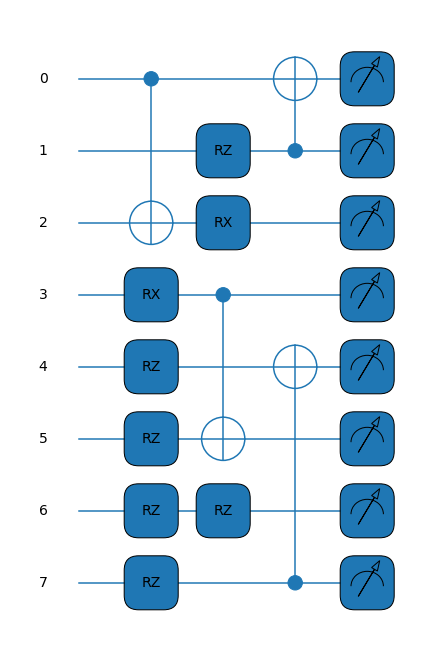

In [55]:
curr_circuit.draw()

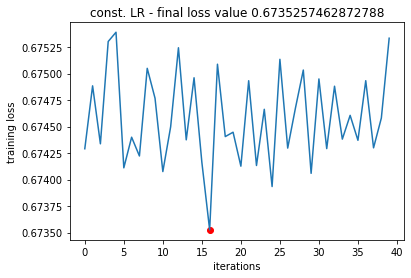

In [36]:
curr_circuit.plot_loss("const. LR - final loss value " + str(1- curr_circuit.fitnesses[curr_circuit.best_loss_idx]))

##### 1D

In [50]:

max_moments = 2
num_one_gates = 3
num_two_gates = 1

random_tensor = generate_random_tensor(n_qubits, num_one_gates, num_two_gates, max_moments)

curr_circuit = IndividualCircuit(random_tensor, probability_pt, num_one_gates, num_two_gates, n_qubits, 1)

In [51]:
params = curr_circuit.params

In [52]:
curr_circuit.assign_params = params

In [53]:
curr_circuit.train_fitness()

In [54]:
curr_circuit.get_fitness()

tensor(0.66719093, requires_grad=True)

In [55]:
curr_circuit.fitnesses[curr_circuit.best_loss_idx]

tensor(0.66719093, requires_grad=True)

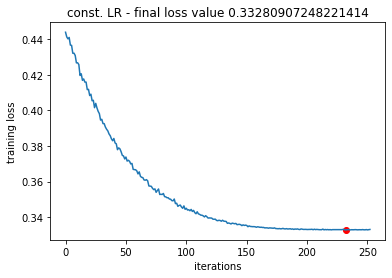

In [56]:
curr_circuit.plot_loss("const. LR - final loss value " + str(1- curr_circuit.fitnesses[curr_circuit.best_loss_idx]))

In [42]:
curr_circuit.LR

[]

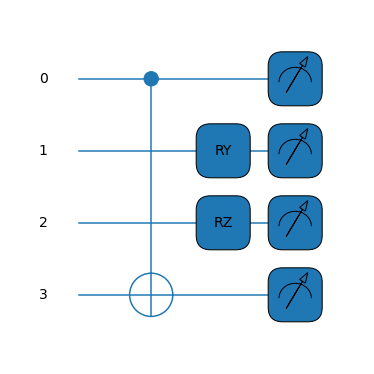

In [49]:
curr_circuit.draw()

In [38]:
import copy

Loss roughness: 0.8947368421052632
Reducing LR :0.01 → 0.006666666666666667


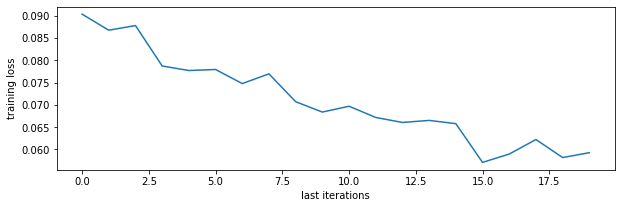

Loss roughness: 0.7894736842105263
Reducing LR :0.006666666666666667 → 0.0044444444444444444


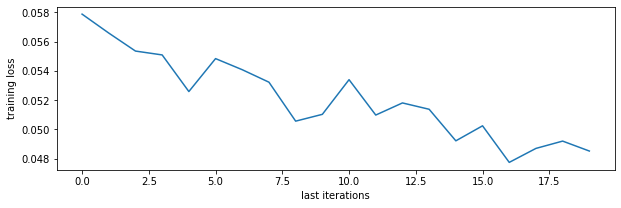

Loss roughness: 0.8947368421052632
Reducing LR :0.0044444444444444444 → 0.002962962962962963


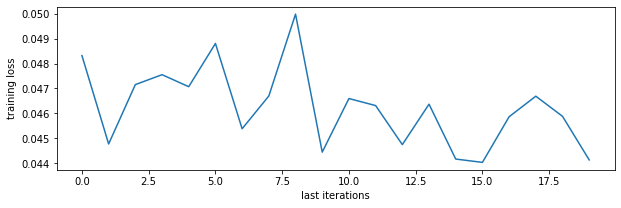

Loss roughness: 0.7894736842105263
Reducing LR :0.002962962962962963 → 0.0019753086419753087


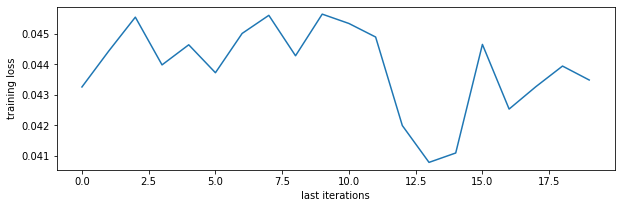

Loss roughness: 0.8947368421052632
Reducing LR :0.0019753086419753087 → 0.0013168724279835392


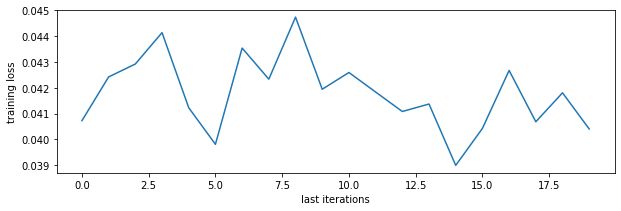

tensor(0.96100508, requires_grad=True)

In [41]:
curr_circuit2 = IndividualCircuit(tensor, probability_pt, num_one_gates, num_two_gates, n_qubits)
curr_circuit2.assign_params(curr_circuit.params)
curr_circuit2.train_fitness()
curr_circuit2.get_fitness()

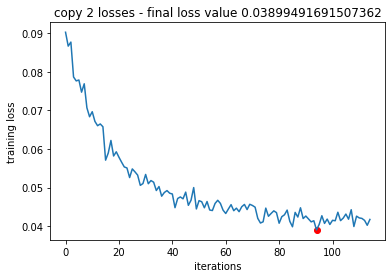

In [42]:
curr_circuit2.plot_loss("copy 2 losses - final loss value " + str(1- curr_circuit2.fitnesses[curr_circuit2.best_loss_idx]))

In [44]:
curr_circuit2.LR

[0.01,
 tensor(0.00666667, requires_grad=True),
 tensor(0.00444444, requires_grad=True),
 tensor(0.00296296, requires_grad=True),
 tensor(0.00197531, requires_grad=True),
 tensor(0.00131687, requires_grad=True),
 tensor(0.00087791, requires_grad=True),
 tensor(0.00058528, requires_grad=True),
 tensor(0.00039018, requires_grad=True)]

Loss roughness: 0.631578947368421
Reducing LR :0.01 → 0.006666666666666667


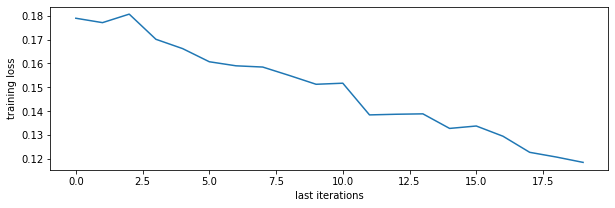

Loss roughness: 0.5263157894736843
Reducing LR :0.006666666666666667 → 0.0044444444444444444


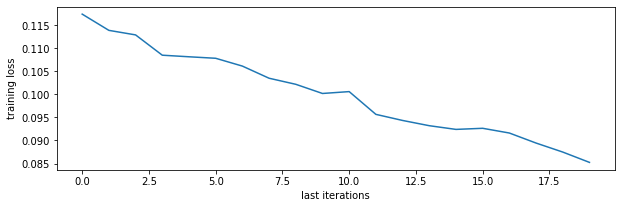

Loss roughness: 0.7894736842105263
Reducing LR :0.0044444444444444444 → 0.002962962962962963


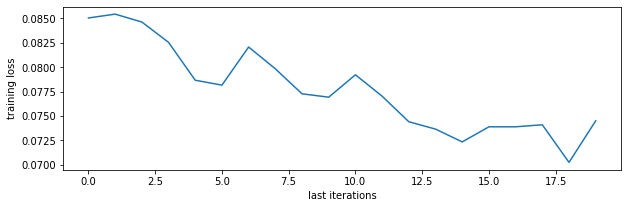

Loss roughness: 0.8421052631578947
Reducing LR :0.002962962962962963 → 0.0019753086419753087


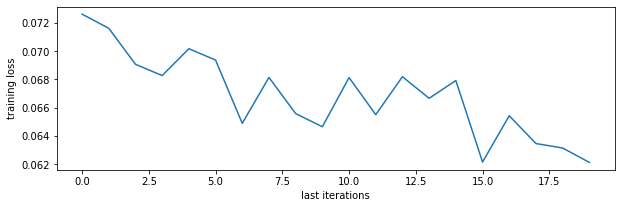

Loss roughness: 0.8947368421052632
Reducing LR :0.0019753086419753087 → 0.0013168724279835392


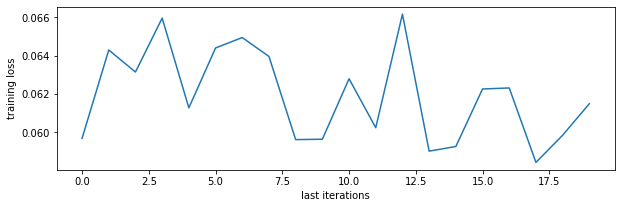

Loss roughness: 0.8421052631578947
Reducing LR :0.0013168724279835392 → 0.0008779149519890262


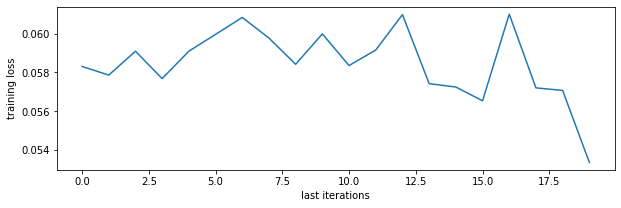

Loss roughness: 0.8421052631578947
Reducing LR :0.0008779149519890262 → 0.0005852766346593508


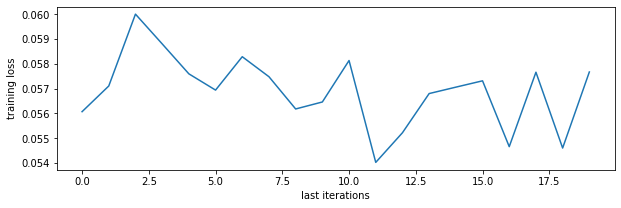

tensor(0.9466388, requires_grad=True)

In [45]:
curr_circuit3 = IndividualCircuit(tensor, probability_pt, num_one_gates, num_two_gates, n_qubits)
curr_circuit3.train_fitness()
curr_circuit3.get_fitness()

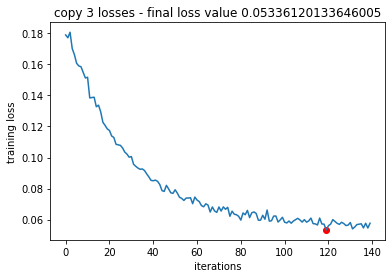

In [46]:
curr_circuit3.plot_loss("copy 3 losses - final loss value " + str(1- curr_circuit3.fitnesses[curr_circuit3.best_loss_idx]))

In [47]:
curr_circuit3.LR

[0.01,
 tensor(0.00666667, requires_grad=True),
 tensor(0.00444444, requires_grad=True),
 tensor(0.00296296, requires_grad=True),
 tensor(0.00197531, requires_grad=True),
 tensor(0.00131687, requires_grad=True),
 tensor(0.00087791, requires_grad=True),
 tensor(0.00058528, requires_grad=True)]

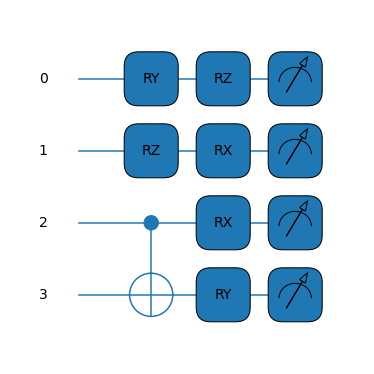

In [153]:
curr_circuit.draw("")

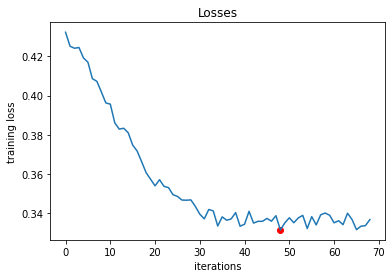

In [58]:
curr_circuit.plot_loss("Losses")

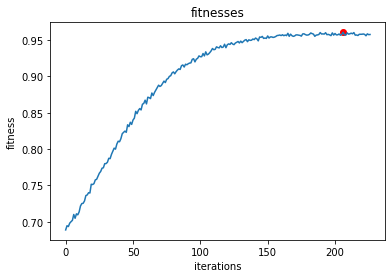

In [68]:
curr_circuit.plot_fitness()

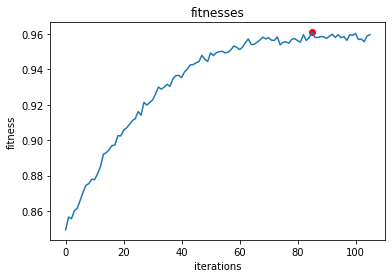

In [69]:
curr_circuit2.plot_fitness()

In [34]:
max_moments = 2
num_one_gates = 3
num_two_gates = 1
random_tensor = generate_random_tensor(n_qubits, num_one_gates ,num_two_gates, max_moments)
num_params = get_num_params(random_tensor, n_qubits, num_one_gates, 1)
init_params = (2.*np.pi)*np.random.random(num_params)
convert_tensor_to_circuit(random_tensor, init_params, n_qubits, num_one_gates, num_two_gates)
# curr_circuit = IndividualCircuit(random_tensor, target1d, num_one_gates, num_two_gates, n_qubits)
curr_circuit = IndividualCircuit(random_tensor, probability_pt, num_one_gates, num_two_gates, n_qubits)

In [35]:
curr_circuit.tensor

[[[1, 0, 0, 0, 0], [0, 0, 0, 4, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 2]],
 [[0, 0, 0, 0, 2], [0, 0, 0, 1, 0], [0, 0, 0, 4, 0], [0, 0, 0, 0, 3]]]

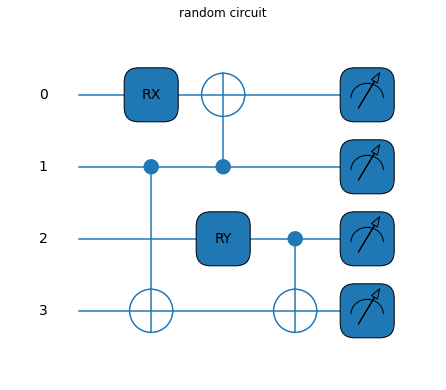

In [36]:
curr_circuit.draw("random circuit")

In [37]:
# n_steps = 2000
# curr_circuit.get_fitness(n_steps=n_steps)
curr_circuit.train_fitness()
curr_circuit.get_fitness()

tensor(0.6371391, requires_grad=True)

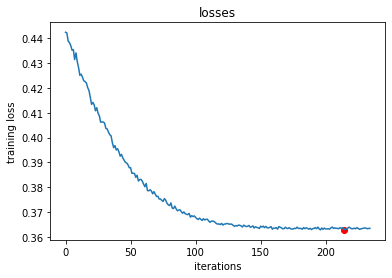

In [38]:
curr_circuit.plot_loss()

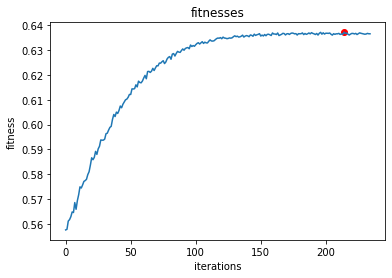

In [39]:
curr_circuit.plot_fitness()

In [34]:
def trace_distance(rho, sigma):
    """
    Compute the trace distance between two matrices

    :param rho: matrix 1
    :param sigma: matrix 2
    :return: a floating point number greater than 0.
    """
    return 0.5 * np.linalg.norm(rho - sigma, 1) 

In [100]:
max_moments = 4
random_tensor1 = np.array(generate_random_tensor(n_qubits, num_one_gates ,num_two_gates, max_moments))
random_tensor2 = np.array(generate_random_tensor(n_qubits, num_one_gates ,num_two_gates, max_moments))

In [29]:
num_params1 = get_num_params(random_tensor1 , n_qubits, num_one_gates, num_two_gates)
init_params1 = (2.*np.pi)*np.random.random(num_params1)
curr_circuit1 = IndividualCircuit(random_tensor1, init_params1, target1d, num_one_gates, num_two_gates, n_qubits)


num_params2 = get_num_params(random_tensor2, n_qubits, num_one_gates, num_two_gates)
init_params2 = (2.*np.pi)*np.random.random(num_params2)
curr_circuit2 = IndividualCircuit(random_tensor2, init_params2, target1d, num_one_gates, num_two_gates, n_qubits)

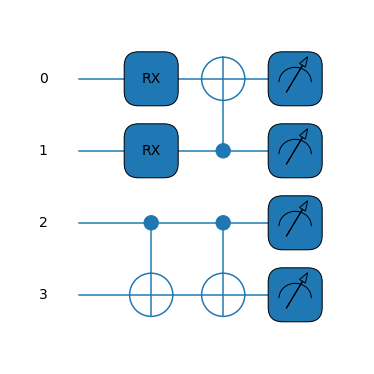

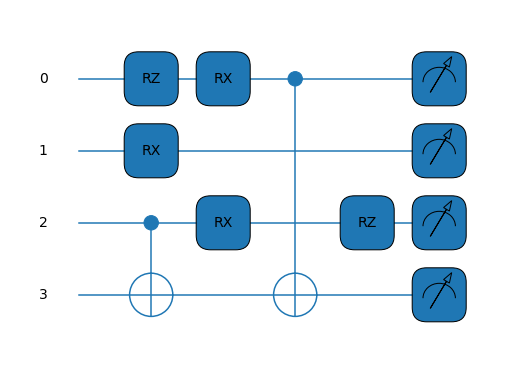

In [30]:
curr_circuit1.draw()
curr_circuit2.draw()

In [31]:
a = np.array(random_tensor1.flatten())
b = np.array(random_tensor2.flatten())

In [32]:
trace_distance(a,b)

ValueError: operands could not be broadcast together with shapes (48,) (72,) 

### Groups of Circuits as Population

In [56]:
class Population:
    def __init__(self):
        self.pop_size = 0
        self.individuals = []
        self.fittest = None
        self.least_fittest = None
        self.max_fitness = 0.0
        self.values = []
    
    def fill_population(self, pop_size, target, num_one_gates, num_two_gates, max_moments, n_qubits, dimension):
        self.pop_size += pop_size        
        for i in range(pop_size):
            random_tensor = generate_random_tensor(n_qubits, num_one_gates, num_two_gates, max_moments)
            curr_circuit = IndividualCircuit(random_tensor, target, num_one_gates, num_two_gates, n_qubits, dimension)
            self.individuals.append(curr_circuit)
        self.update()
    
    
    def add_circuit(self, circuit):
        self.individuals.append(circuit)
        self.pop_size += 1
        self.update()
    
    def add_circuits(self, circuits, increase_size=True):
        self.individuals.extend(circuits.individuals)
        if increase_size:
            self.pop_size += len(circuits)
        self.update()
        
        
    def update(self):
        self.individuals.sort(key=lambda circuit:circuit.fitness, reverse=True)
        self.fittest = self.individuals[0]
        self.least_fittest = self.individuals[-1]
        
    
    def train_all(self):
        start_time = time.time()
        procs = []
        for circuit in self.individuals:
            proc = mp.Process(target=circuit.train_fitness())
            procs.append(proc)
            proc.start()
        
        for proc in procs:
            proc.join()
        
        end_time = time.time()
        exec_time = end_time - start_time
        print("Execution time multiprocessing {}".format(exec_time))
        self.update()
        
        
    def train_linear(self):
        start_time = time.time()
        for circuit in self.individuals:
            circuit.train_fitness()
        end_time = time.time()
        exec_time = end_time - start_time
        print("Execution time linear {}".format(exec_time))
        
    
    
    def get_fittests(self, num_fittests):
        self.fittest = self.individuals[0]
        return self.individuals[:num_fittests]
        
    
    def remove_circuit(self, circuit):
        if self.pop_size <= 0:
            print("can't remove")
        else:
            self.individuals.remove(circuit)
            self.pop_size -=1
            self.update()
            
    
    
    def get_least_fittest(self):
        self.least_fittest = self.individuals[-1]
        # min_fit = 1.0
        idx = -1
        # for i in range(self.pop_size):
        #     if self.individuals[i].get_fitness() < min_fit:
        #         min_fit = self.individuals[i].get_fitness()
        #         self.least_fittest = self.individuals[i]
        #         idx = i
        return self.least_fittest, idx
        
        

### Testing Population

#### 2D 

In [57]:
pop = Population()
pop_size = 10
max_moments = 2
num_one_gates = 3
num_two_gates = 1
# pop.fill_population(pop_size, target1d, num_one_gates, num_two_gates, max_moments, n_qubits)
pop.fill_population(pop_size, target_1d, num_one_gates, num_two_gates, max_moments, n_qubits, 2)

In [58]:
pop.train_all()

Execution time multiprocessing 3.4290337562561035


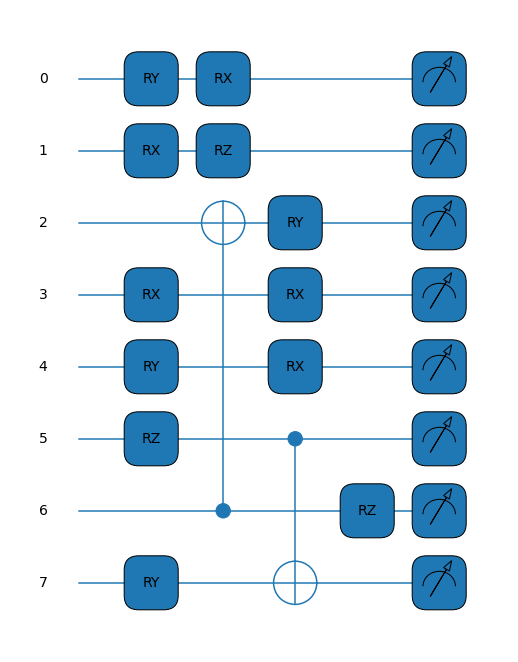

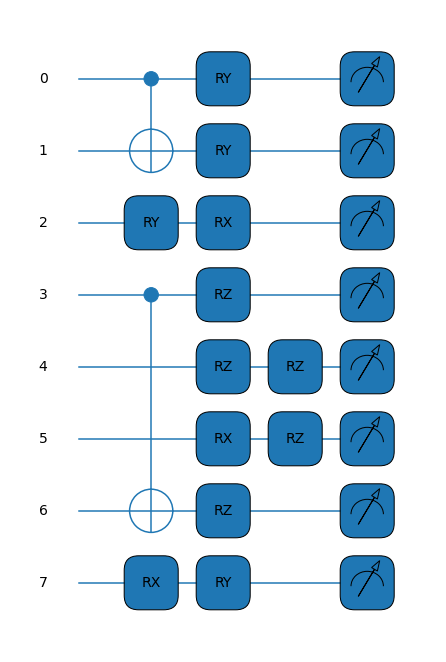

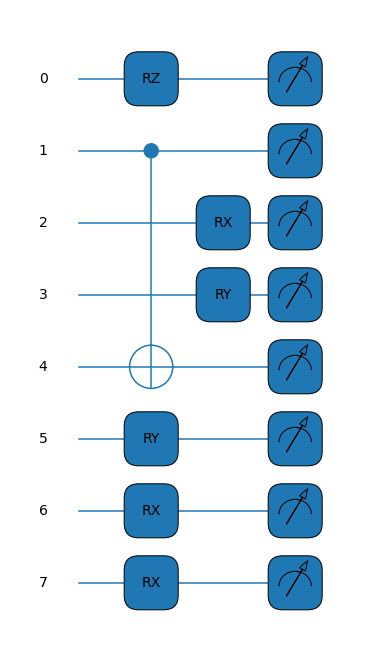

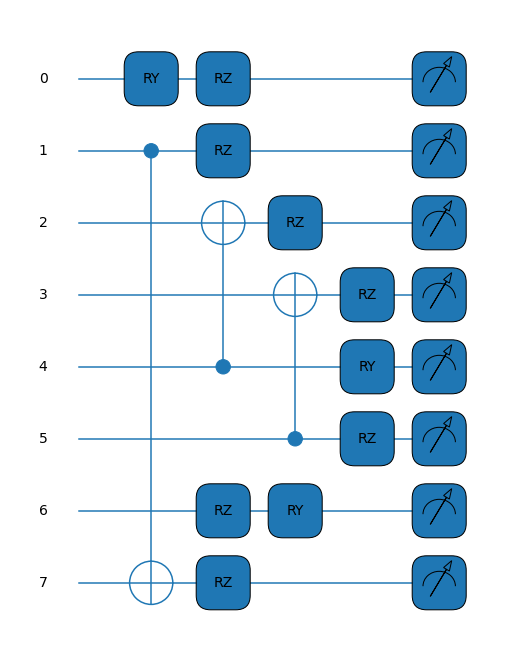

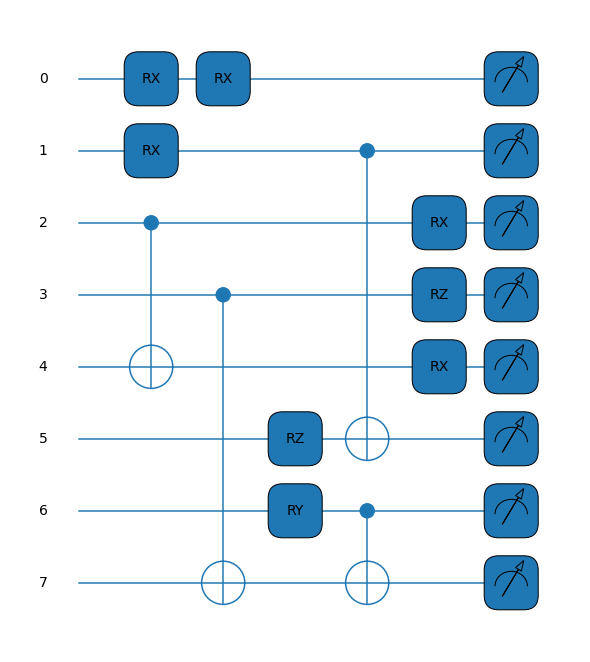

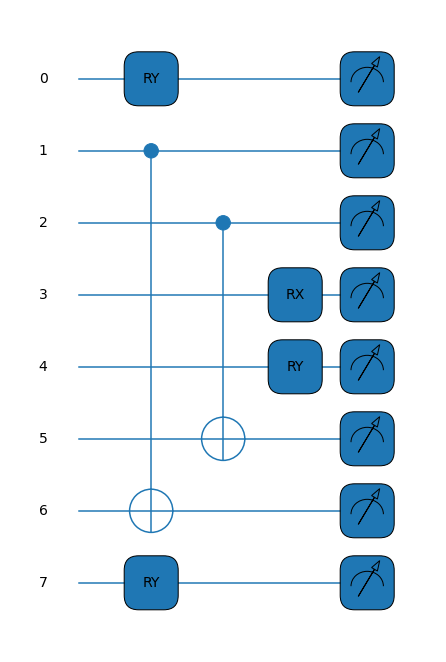

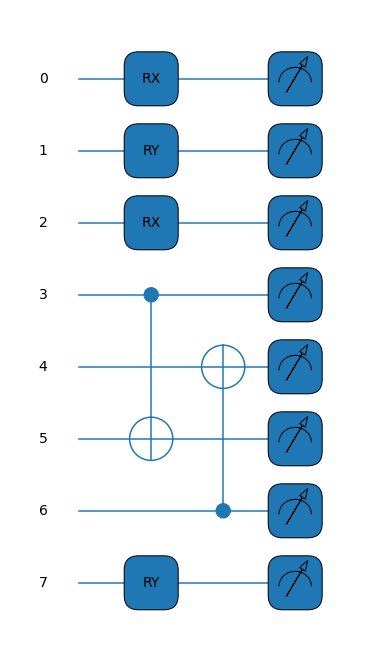

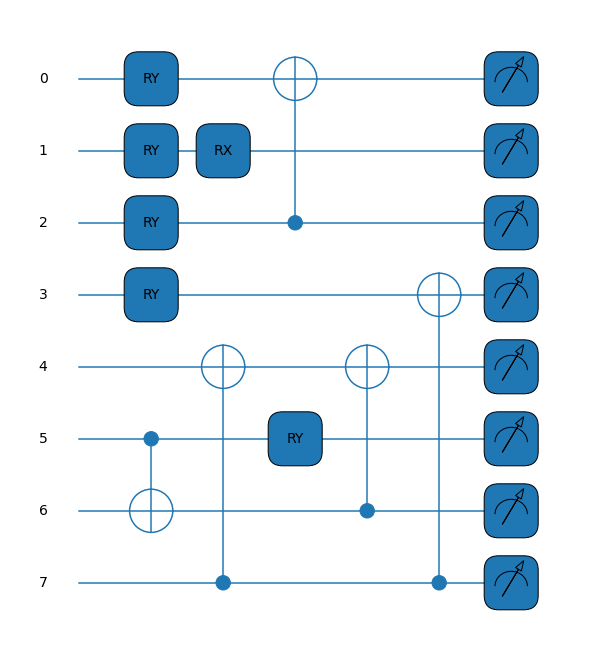

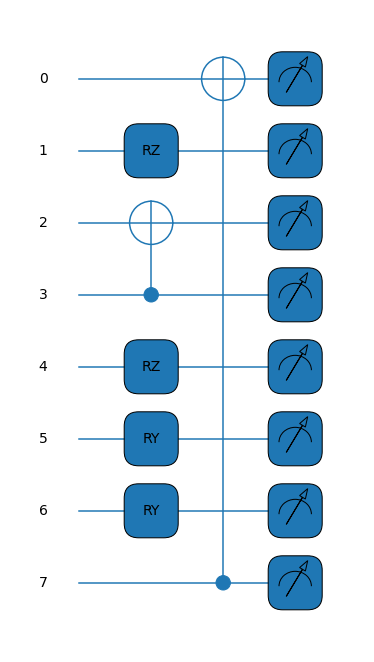

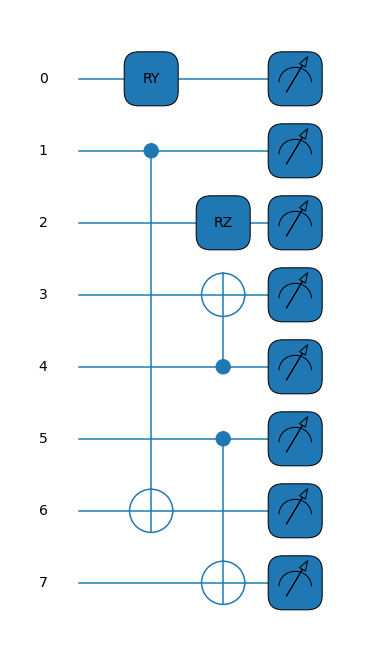

In [59]:
for circuit in pop.individuals:
    circuit.draw()

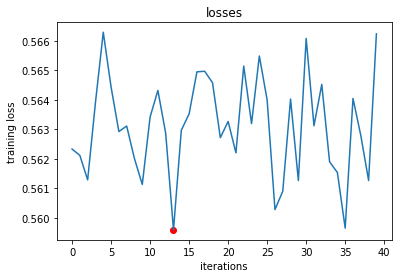

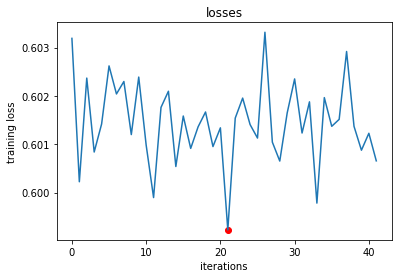

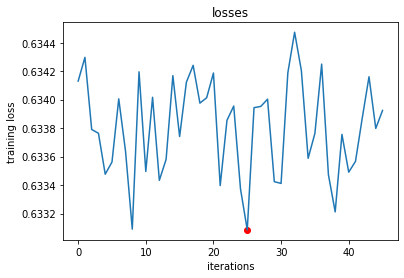

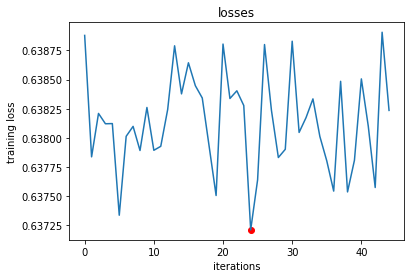

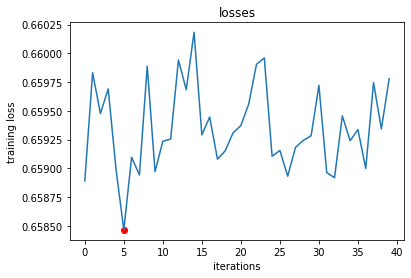

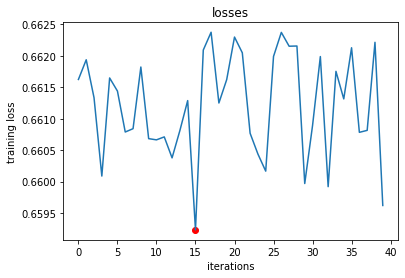

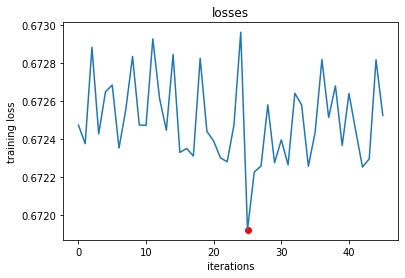

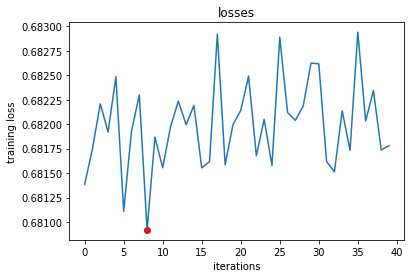

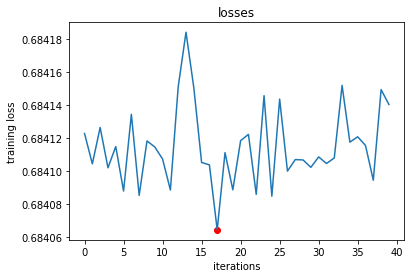

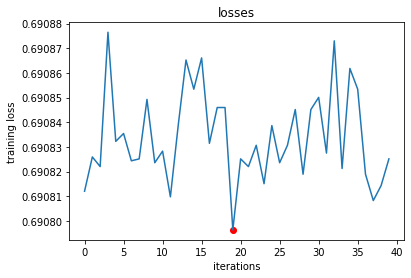

In [51]:
for circuit in pop.individuals:
    circuit.plot_loss()

#### 1D

In [32]:
pop = Population()
pop_size = 10
max_moments = 2
num_one_gates = 3
num_two_gates = 1
# pop.fill_population(pop_size, target1d, num_one_gates, num_two_gates, max_moments, n_qubits)
pop.fill_population(pop_size, probability_pt, num_one_gates, num_two_gates, max_moments, n_qubits)

In [33]:
pop.train_all()

/usr/local/lib/python3.8/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Execution time multiprocessing 143.2015209197998


In [29]:
start_time = time.time()
with mp.get_context("spawn").Pool(processes=pop_size) as pool:
    for circuit in pop.individuals:
        pool.starmap(circuit.train_fitness(), [])
end_time = time.time()
exec_time = end_time - start_time
print("Execution time multiprocessing {}".format(exec_time))

Execution time multiprocessing 76.4148485660553


In [30]:
start_time = time.time()
procs = []
for circuit in pop.individuals:
    proc = mp.Process(target=circuit.train_fitness())
    procs.append(proc)
    proc.start()

for proc in procs:
    proc.join()

end_time = time.time()
exec_time = end_time - start_time
print("Execution time multiprocessing {}".format(exec_time))
pop.update()

Execution time multiprocessing 0.565972089767456


In [41]:
import copy

In [45]:
pop2 = copy.deepcopy(pop)

In [46]:
pop2.train_linear()

Execution time linear 0.0922846794128418


In [38]:
# multiprocessing
pop.train_all()

Execution time multiprocessing 0.13933825492858887


In [40]:
# linear
pop.train_linear()

Execution time linear 0.0846245288848877


In [78]:
pop.fittest

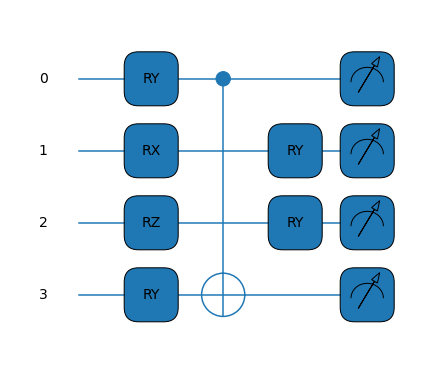

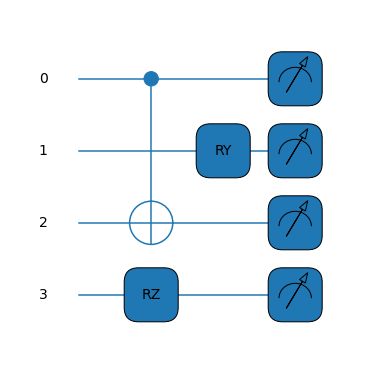

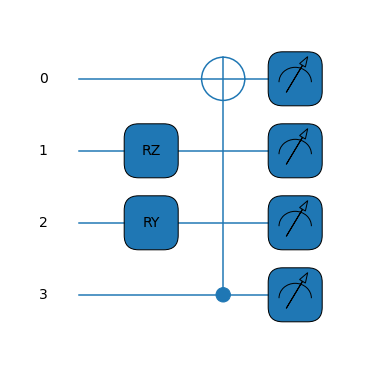

In [31]:
for circuit in pop.individuals:
    circuit.draw()

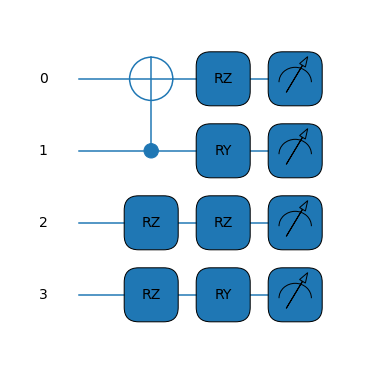

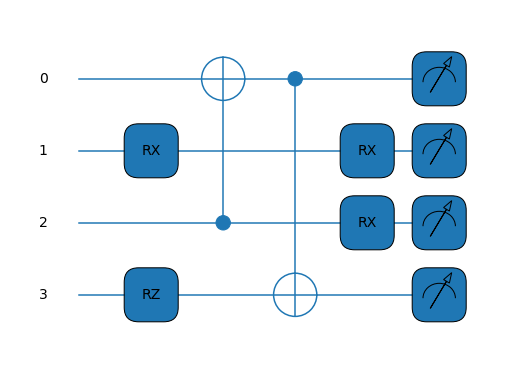

In [95]:
for circuit in pop2.individuals:
    circuit.draw()

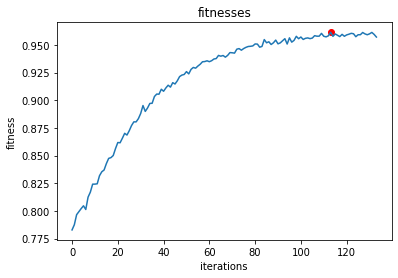

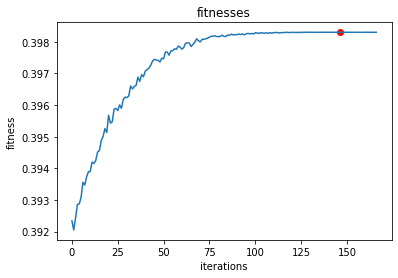

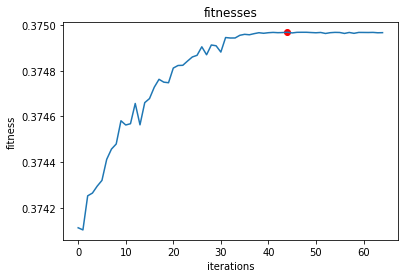

In [32]:
for circuit in pop.individuals:
    # circuit.plot_loss()
    circuit.plot_fitness()

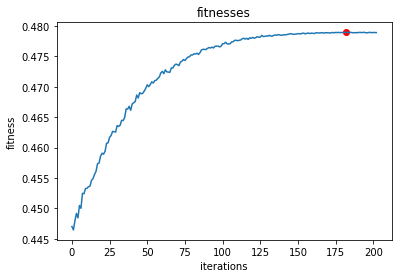

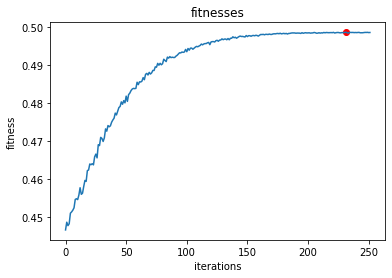

In [97]:
for circuit in pop2.individuals:
    # circuit.plot_loss()
    circuit.plot_fitness()

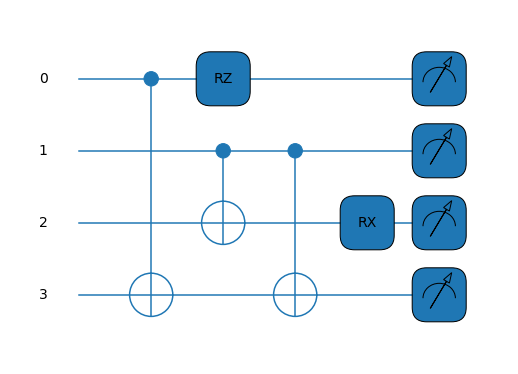

In [82]:
pop.get_fittests(2)[0].draw()

In [95]:
pop.get_least_fittest()

(<__main__.IndividualCircuit at 0x7f9a59fb5d60>, 2)

### Genetic Algorithm

In [59]:
class CircuitOptimizer:
    
    def __init__(self, pop_size, target, num_one_gates, num_two_gates, max_moments, n_qubits):
        self.population = Population()
        self.population.fill_population(pop_size, target, num_one_gates, num_two_gates, max_moments, n_qubits)
        self.generation = 0
        self.pop_size = pop_size
        self.num_one_gates = num_one_gates
        self.num_two_gates = num_two_gates
        self.parents = []
        parents_size = int(pop_size * 0.25)
        if parents_size < 2:
            self.parents_size = 2
        else:
            self.parents_size = parents_size
        self.offsprings = Population()
        self.target = target
        self.n_qubits = n_qubits
        self.population.train_all()
        self.print_info()
    
    def draw_all_circuits(self):
        self.print_info()
        for i in range(len(self.population.individuals)):
            title = "circuit " + str(i+1) + " generation " + str(self.generation) + " fitness: " + str(self.population.individuals[i].get_fitness())
            self.population.individuals[i].draw(title)
            
    
    def get_least_fit_offspring(self):
        self.offsprings.train_all()
        least_fit, idx = self.offsprings.get_least_fittest()
        return least_fit
    
    
    def draw_offsprings(self):
        for i in range(len(self.offsprings.individuals)):
            title = "offspring " + str(i+1) + " generation " + str(self.generation) + " fitness: " + str(self.offsprings.individuals[i].get_fitness())
            self.offsprings.individuals[i].draw(title)
    
                                
    def compare_offsprings(self, draw=False):
        least_fit, idx = self.population.get_least_fittest()
        least_offspring = self.get_least_fit_offspring()
        if least_fit.get_fitness() < least_offspring.get_fitness():
            self.population.individuals[idx] = least_offspring
        self.offsprings = Population()
        if draw:
            self.draw_offsprings()
            
    def train_offsprings(self):
        self.offsprings.train_all()
            
    def add_offsprings(self):
        self.population.add_circuits(self.offsprings, increase_size=False)
        self.population.individuals = self.population.individuals[:-len(self.offsprings.individuals)]
        self.offsprings = Population()
        
    
    
    def print_info(self):
        self.population.update()
        # self.population.get_fittests()
        print("Generation: {} Fittest: {}".format(self.generation, self.population.fittest.get_fitness()))
        
    
    # choose the two most fit
    def selection(self):
        self.parents = self.population.get_fittests(self.parents_size)
        # self.parent1, self.parent2 = self.population.get_fittests(second=True)
        
    
    # choose a random moment as the crossover point, then swap the rest of the moments
    def crossover(self):
        print("entering crossover")
        
        for i in range(0, len(self.parents)-1, 2):
            print("index " + str(i))
            parent1 = self.parents[i]
            parent2 = self.parents[i+1]
            self.crossover_pair(parent1, parent2)
        if len(self.parents) % 2 == 1:
            parent1 = self.parents[-1]
            parent2 = random.choice(self.parents[:len(self.parents)-1])
            self.crossover_pair(parent1, parent2)
        
            
    
    def crossover_pair(self, parent1, parent2):
        if len(parent1.tensor) == 1:
            cross_pt1 = random.randint(1, len(parent1.tensor))
            tensor1 = parent1.get_tensor()
            if len(parent2.tensor) == 1:
                cross_pt2 = random.randint(1, len(parent2.tensor))
                tensor2 = parent2.get_tensor()
            else:
                cross_pt2 = random.randint(1, len(parent2.tensor)-1)
                tensor2 = parent2.get_tensor()[:cross_pt2]
                tensor1 += parent2.get_tensor()[:cross_pt2]
        elif len(parent2.tensor) == 1:
            cross_pt2 = random.randint(1, len(parent2.tensor))
            tensor2 = parent2.get_tensor()
            cross_pt1 = random.randint(1, len(parent1.tensor)-1)
            tensor1 = parent1.get_tensor()[:cross_pt1]
            tensor2 += parent1.get_tensor()[:cross_pt1]
        else:
            cross_pt1 = random.randint(1, len(parent1.tensor)-1)
            cross_pt2 = random.randint(1, len(parent2.tensor)-1)
            tensor1 = parent1.get_tensor()[:cross_pt1] + parent2.get_tensor()[cross_pt2:]
            tensor2 = parent2.get_tensor()[:cross_pt2] + parent1.get_tensor()[cross_pt1:]
            
        
        
        
        params1 = (2.*np.pi)*np.random.random(get_num_params(tensor1, n_qubits, num_one_gates, num_two_gates))
        params2 = (2.*np.pi)*np.random.random(get_num_params(tensor2, n_qubits, num_one_gates, num_two_gates))
        
        self.offsprings.add_circuit(IndividualCircuit(tensor1, self.target, num_one_gates, num_two_gates, n_qubits))
        self.offsprings.add_circuit(IndividualCircuit(tensor2, self.target, num_one_gates, num_two_gates, n_qubits))
    
        
    
    
    
    
    # choose a random point to switch on/off the gate; for two qubit gates, the target gate is changed to a random value
    def mutate(self):
        for i in range(len(self.offsprings.individuals)):
            
            curr_offspring = self.offsprings.individuals[i]
            mutate_gate = random.randint(0, num_one_gates-1)
            mutate_moment = random.randint(0, len(curr_offspring.tensor)-1)
            qubits_options = []
            curr_moment = curr_offspring.tensor[mutate_moment]

            ## mutate one qubit gate
            if random.randint(0, 1):
                
                for q in range(len(curr_moment)):
                    curr_qubit = curr_moment[q]
                    if not any(curr_qubit[num_one_gates:]):
                        qubits_options.append(q)
                
                
                if len(qubits_options) == 0:
                    i -= 1
                    continue
                
                
                mutate_qubit = random.choice(qubits_options)
                qubits_options.remove(mutate_qubit)  
                
                
                q = curr_offspring.tensor[mutate_moment][mutate_qubit]
                q[mutate_gate] = curr_offspring.tensor[mutate_moment][mutate_qubit][mutate_gate] ^ 1
                for i in range(self.num_one_gates + self.num_two_gates):
                    if q[i] and not i == mutate_gate:
                        q[i] = 0
                                
                
                
                
            # mutate two qubit gate
            else:
                two_gates_idx = self.num_one_gates + random.randrange(0, self.num_two_gates*2, 2)
                
                for q in range(len(curr_moment)):
                    curr_qubit = curr_moment[q]                        
                    if not any(curr_qubit[:two_gates_idx]):
                        if two_gates_idx + 2 < len(curr_qubit):
                            if not any(curr_qubit[two_gates_idx+2:]):
                                qubits_options.append(q)
                        else:
                            qubits_options.append(q)
                
                if len(qubits_options) <= 1:
                    i -= 1
                    continue
                
                mutate_qubit = random.choice(qubits_options)
                qubits_options.remove(mutate_qubit)  
                
                no_gates_qubits = []
                for qubit in qubits_options:
                    if not any(curr_moment[qubit]):
                        no_gates_qubits.append(qubit)
                
                if not curr_moment[mutate_qubit][two_gates_idx] == 0:
                    choice = random.randint(0,2)
                    if choice == 0:
                        self.swap(qubits_options, curr_moment, mutate_qubit, two_gates_idx)
                    elif choice == 1:
                        self.turn_off(qubits_options, curr_moment, mutate_qubit, two_gates_idx) 
                    else:
                        if len(no_gates_qubits) == 0:
                            i -= 1
                            continue
                        self.mutate_one(no_gates_qubits, curr_moment, mutate_qubit, two_gates_idx)
                        
                elif not curr_moment[mutate_qubit][two_gates_idx+1] == 0:
                    choice = random.randint(0,2)
                    if choice == 0:
                        self.swap(qubits_options, curr_moment, mutate_qubit, two_gates_idx+1, target=True)
                    elif choice == 1:
                        self.turn_off(qubits_options, curr_moment, mutate_qubit, two_gates_idx+1, target=True)
                    else:
                        if len(no_gates_qubits) == 0:
                            i -= 1
                            continue
                        self.mutate_one(no_gates_qubits, curr_moment, mutate_qubit, two_gates_idx+1, target=True)
                    
                else:
                    if len(no_gates_qubits) == 0:
                        i -= 1
                        continue
                    else:
                        new_qubit = random.choice(no_gates_qubits)
                        curr_moment[mutate_qubit][two_gates_idx] = new_qubit + 1
                        curr_moment[new_qubit][two_gates_idx+1] = mutate_qubit + 1
                    
                    
    def plot_all(self):
        for circuit in self.population.individuals:
            circuit.plot_fitness()
            
    
    def plot_offsprings(self):
        for circuit in self.offsprings.individuals:
            circuit.plot_fitness()
            
                    
    def swap(self, qubits_options, curr_moment, mutate_qubit, two_gates_idx, target=False):
        if target:
            new_target = curr_moment[mutate_qubit][two_gates_idx] -1
            new_control = mutate_qubit
            curr_moment[mutate_qubit][two_gates_idx-1] = new_target + 1
            curr_moment[new_target][two_gates_idx] = new_control + 1
            curr_moment[mutate_qubit][two_gates_idx] = 0
            curr_moment[new_target][two_gates_idx - 1] = 0
        else:
            new_control = curr_moment[mutate_qubit][two_gates_idx] - 1
            new_target = mutate_qubit
            curr_moment[mutate_qubit][two_gates_idx+1] = new_control + 1
            curr_moment[new_control][two_gates_idx] = new_target + 1
            curr_moment[mutate_qubit][two_gates_idx] = 0
            curr_moment[new_control][two_gates_idx+1] = 0
    
    def turn_off(self, qubits_options, curr_moment, mutate_qubit, two_gates_idx, target=False):
        if target:
            curr_control = curr_moment[mutate_qubit][two_gates_idx] -1
            curr_moment[curr_control][two_gates_idx-1] = 0
            curr_moment[mutate_qubit][two_gates_idx] = 0
        else:
            curr_target = curr_moment[mutate_qubit][two_gates_idx] - 1
            curr_moment[curr_target][two_gates_idx+1] = 0
            curr_moment[mutate_qubit][two_gates_idx] = 0
    
    def mutate_one(self, qubits_options, curr_moment, mutate_qubit, two_gates_idx, target=False):
        new_qubit = random.choice(qubits_options)
        target_q = curr_moment[mutate_qubit][two_gates_idx]
        
        curr_moment[new_qubit][two_gates_idx] = target_q
        curr_moment[mutate_qubit][two_gates_idx] = 0
        if target:
            curr_moment[target_q-1][two_gates_idx-1] = new_qubit+1
        else:
            curr_moment[target_q-1][two_gates_idx+1] = new_qubit+1
        qubits_options.remove(new_qubit)
        
    

#### Testing Optimizer

#### 2D

In [62]:
num_one_gates = 3
num_two_gates = 1
max_moments = 3
n_qubits = 8

In [63]:
pop_size = 20

opt = CircuitOptimizer(pop_size, target_1d, num_one_gates, num_two_gates, max_moments, n_qubits, 2)

Execution time multiprocessing 7.028435468673706
Generation: 0 Fittest: 0.6097359035876108


Generation: 0 Fittest: 0.6097359035876108


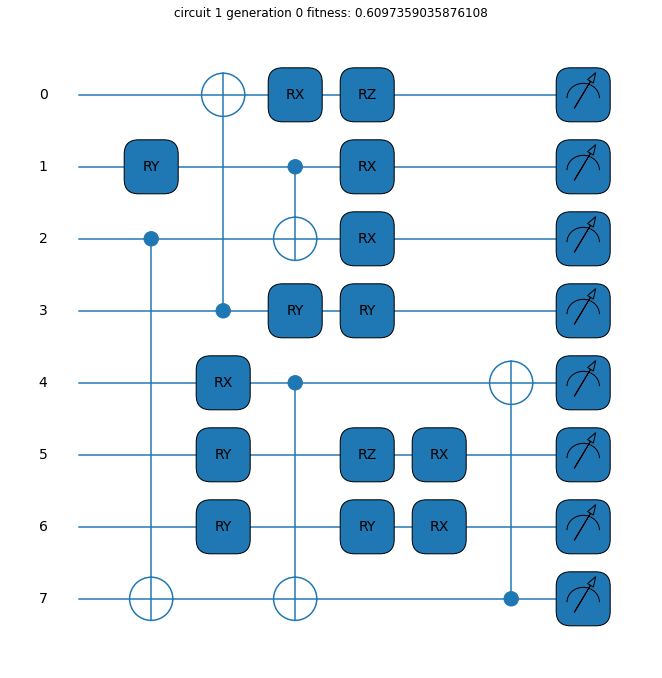

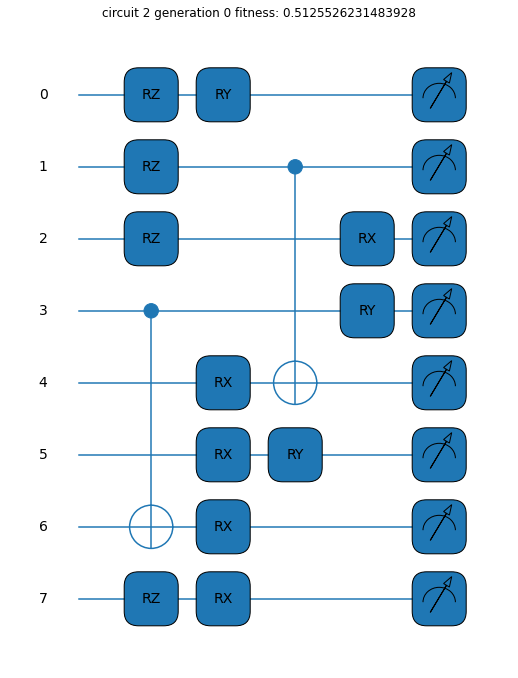

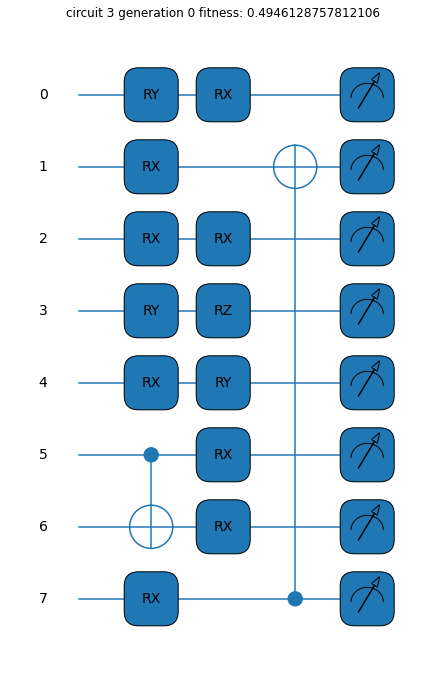

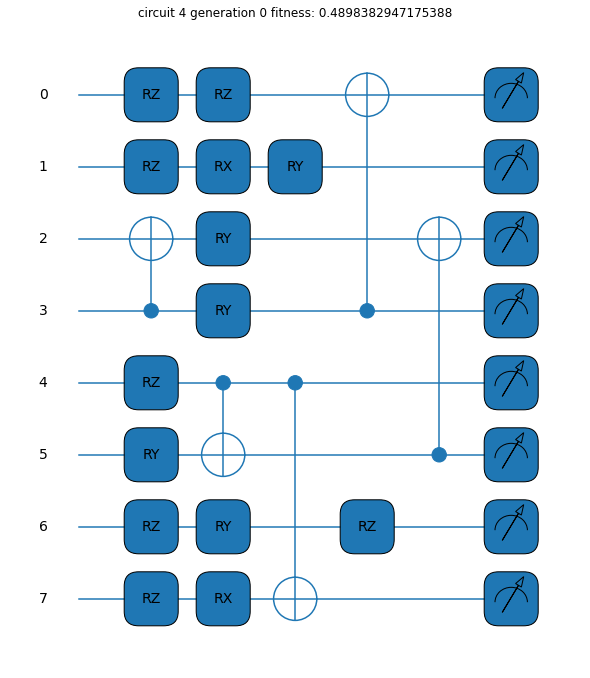

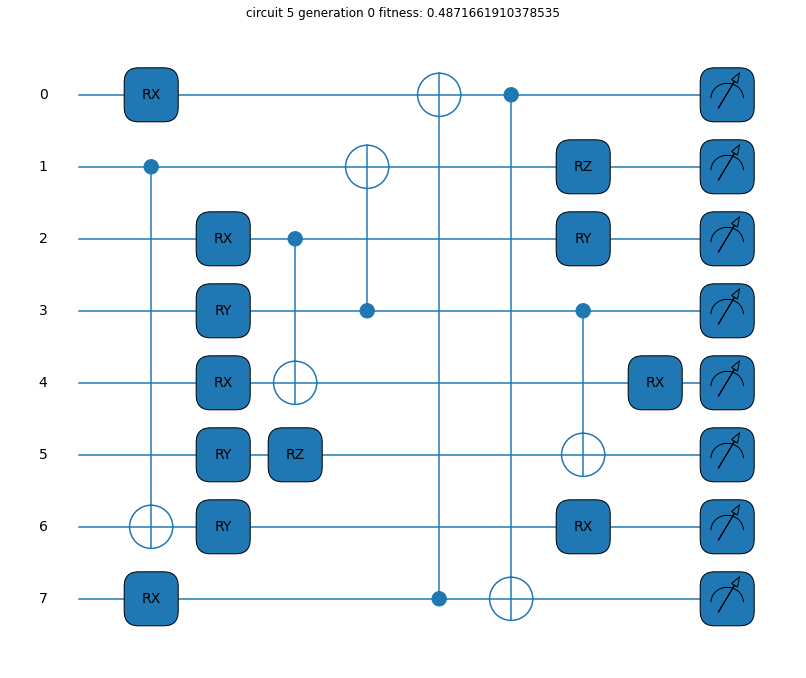

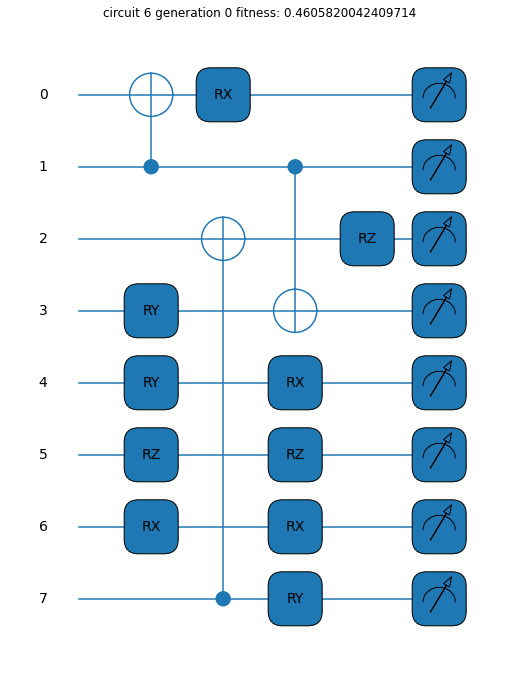

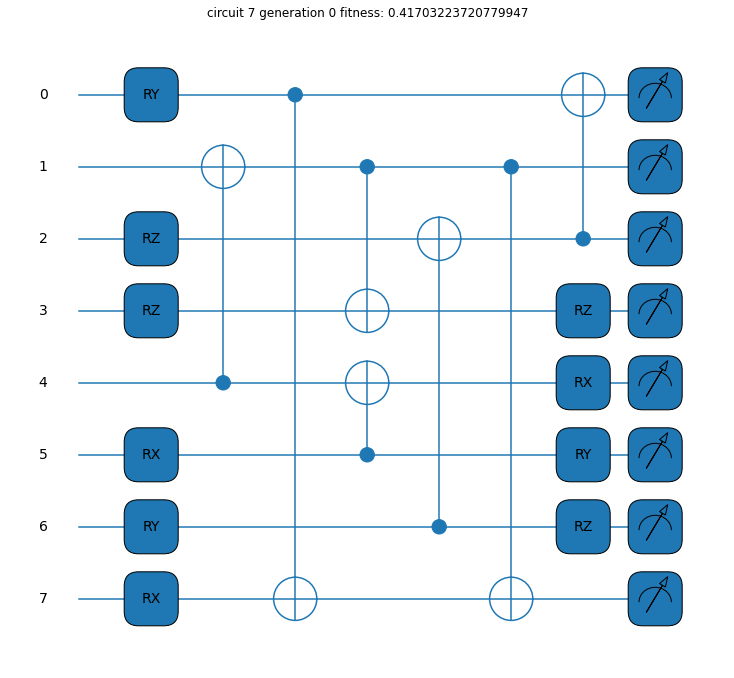

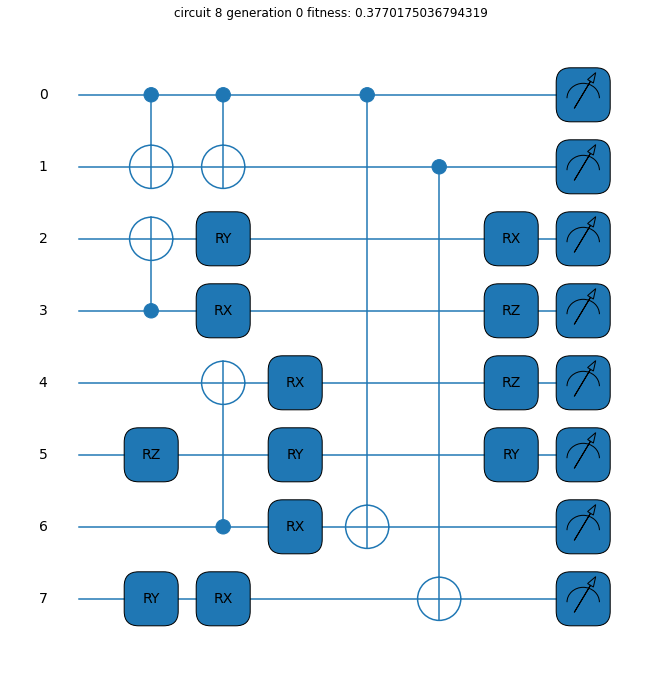

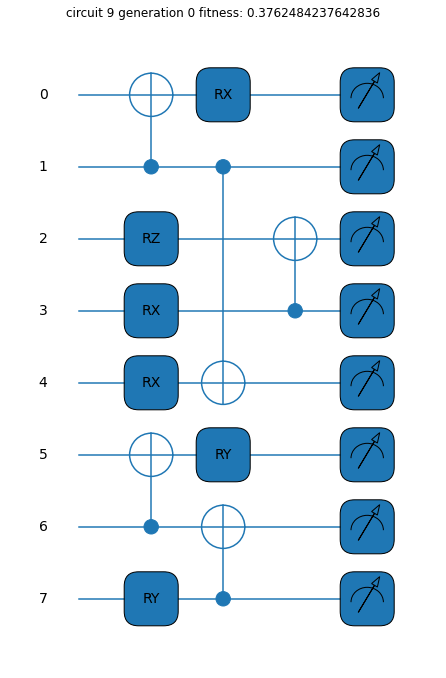

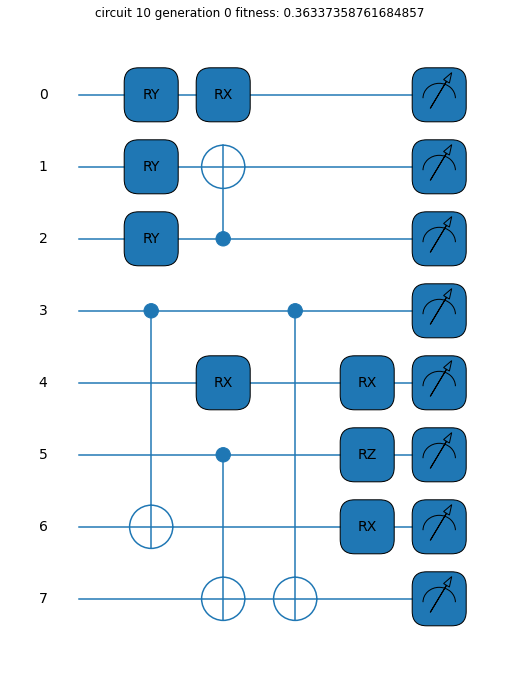

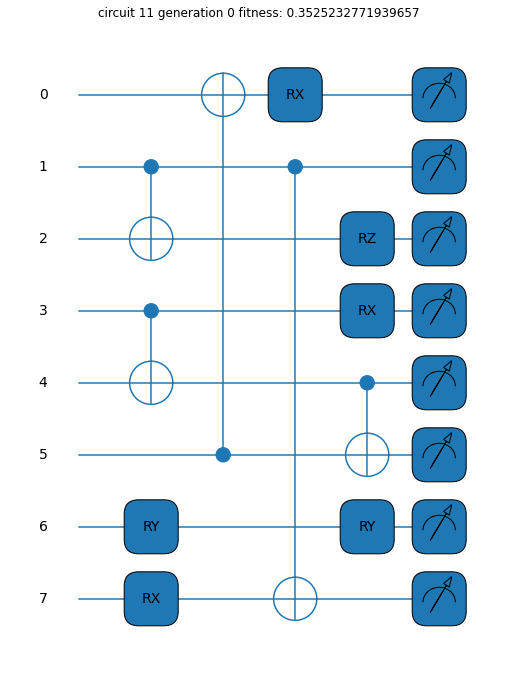

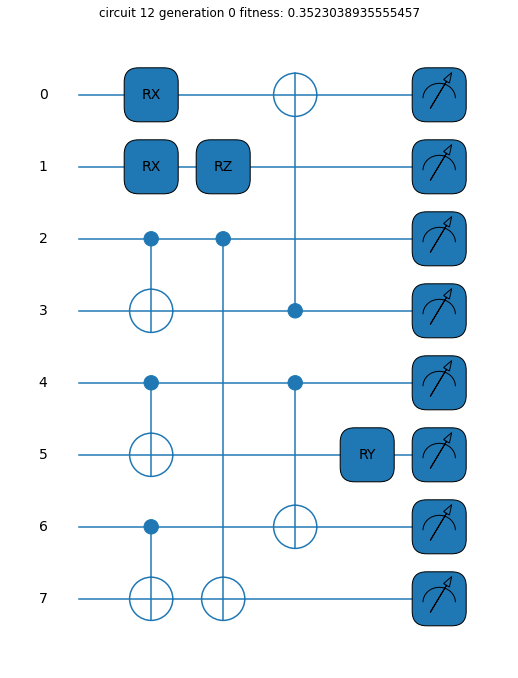

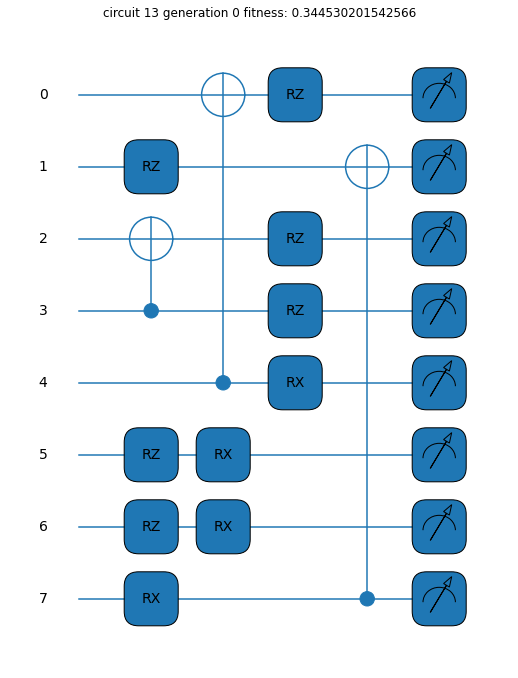

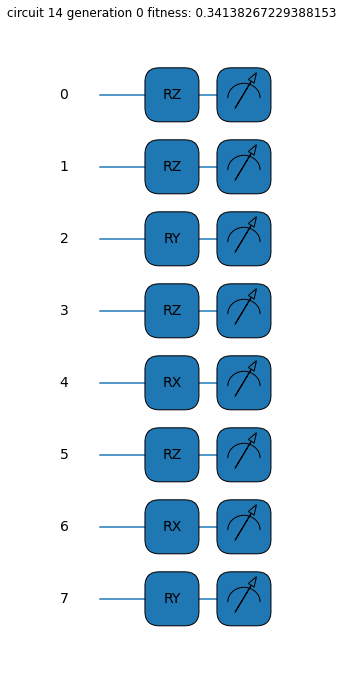

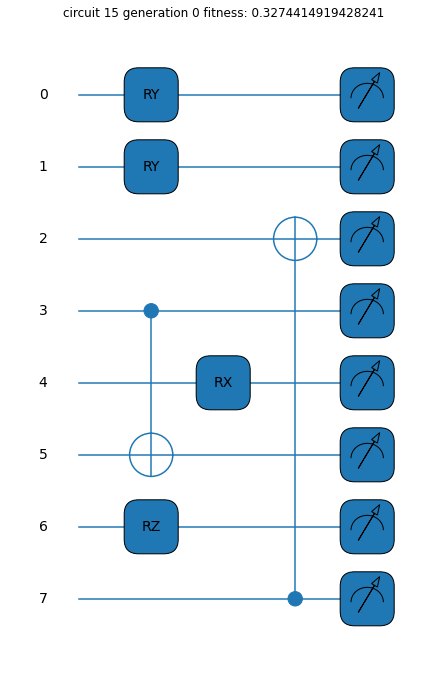

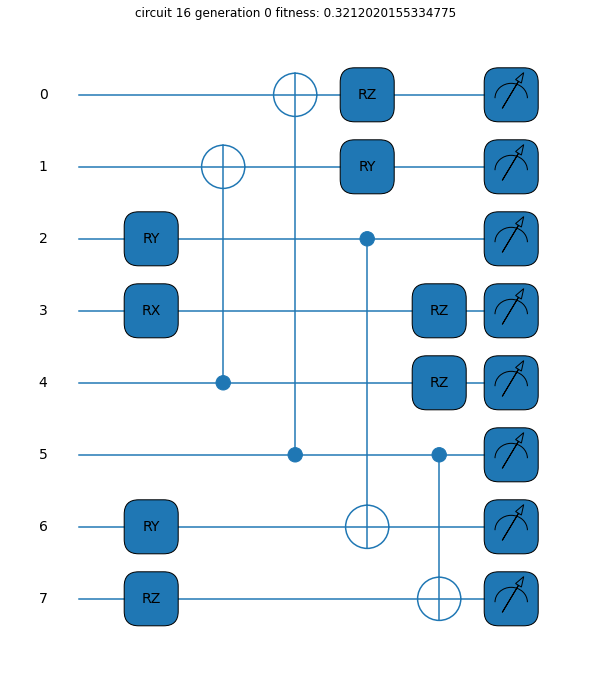

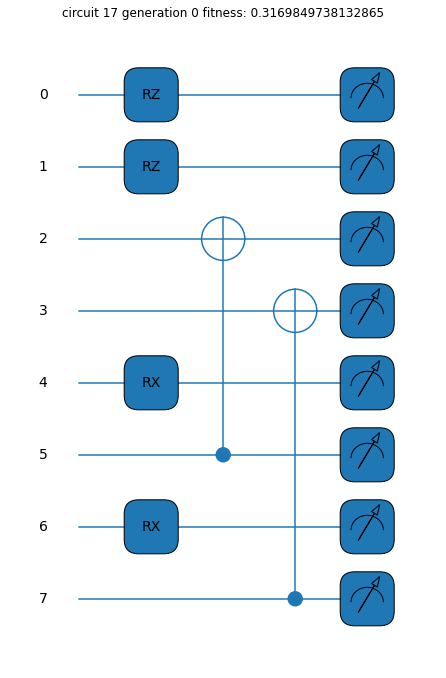

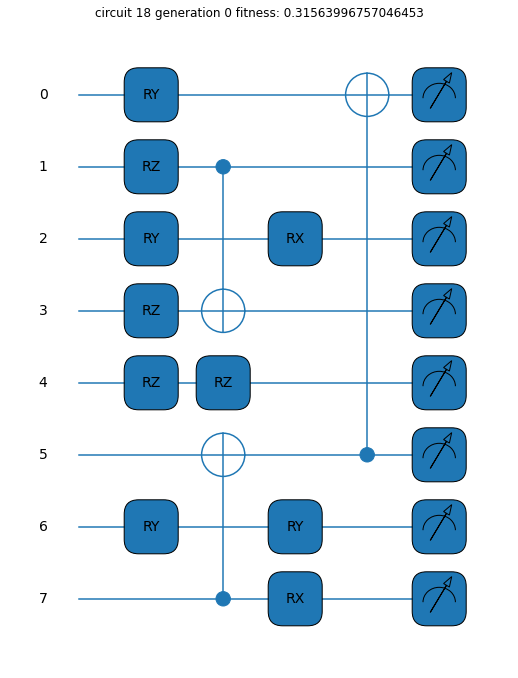

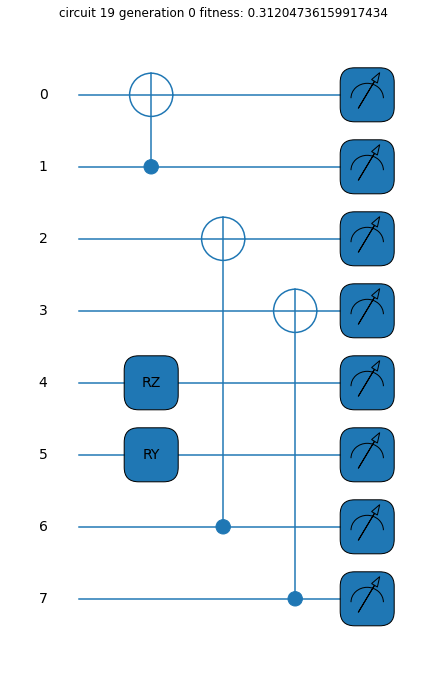

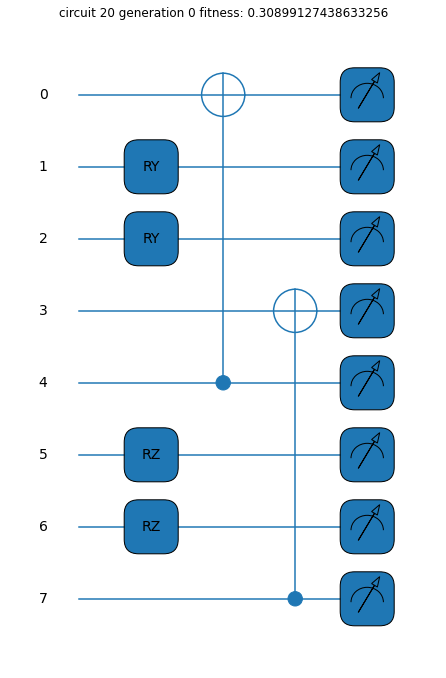

In [65]:
opt.draw_all_circuits()

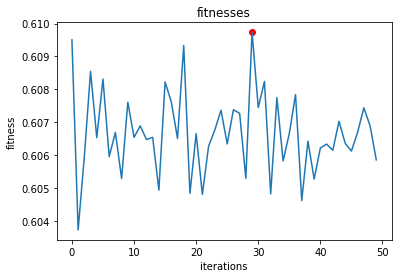

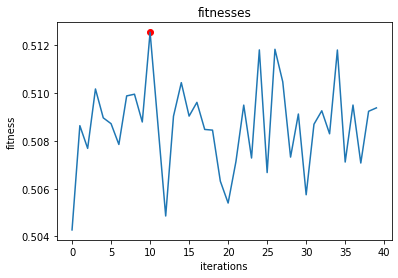

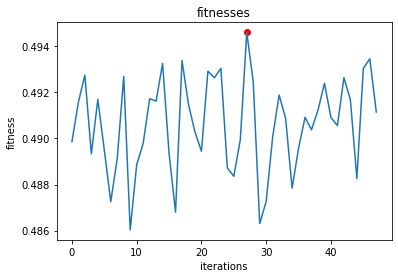

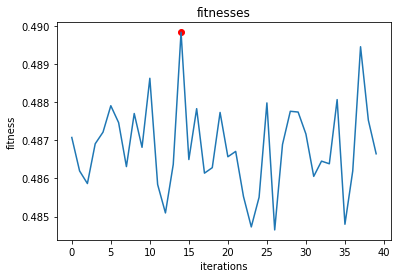

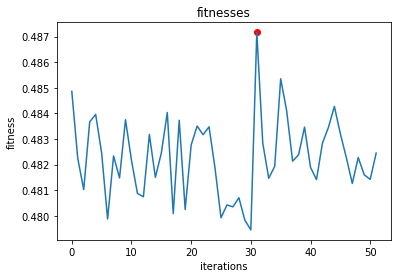

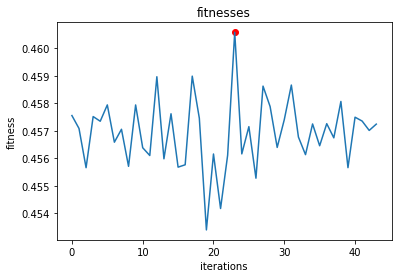

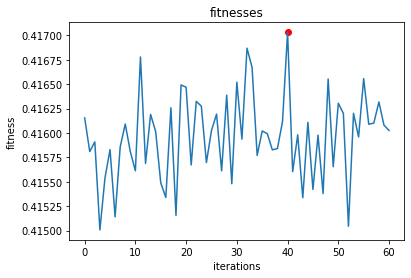

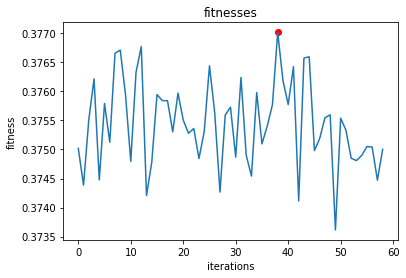

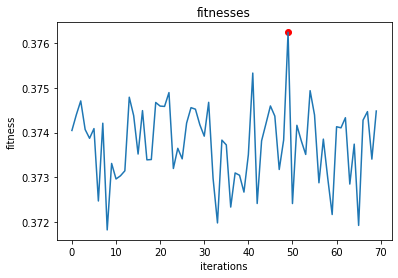

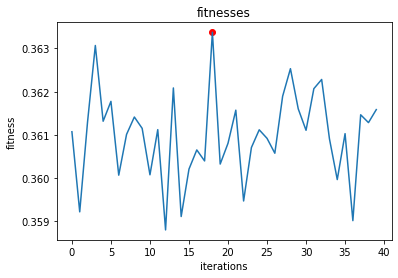

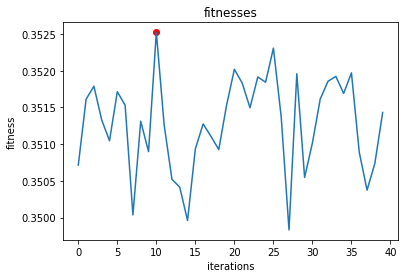

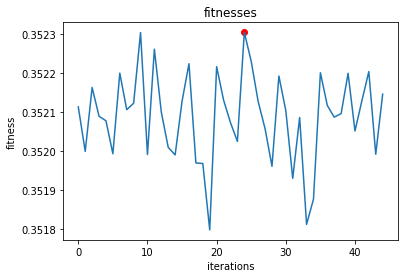

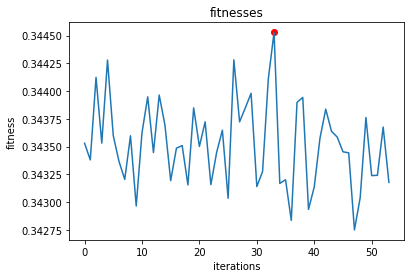

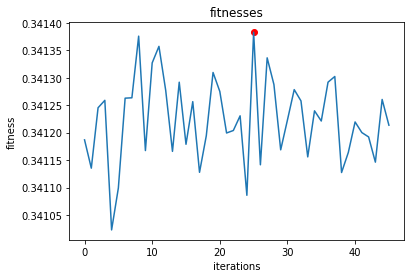

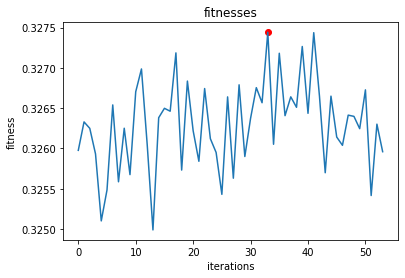

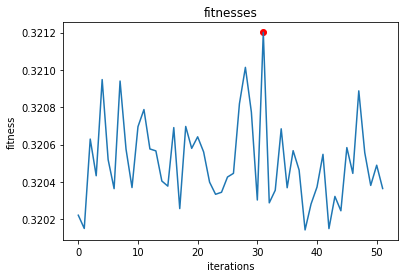

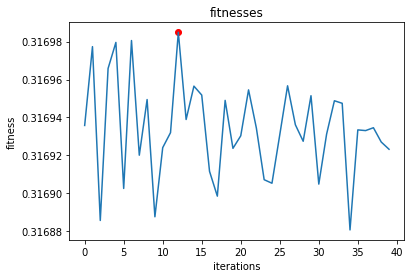

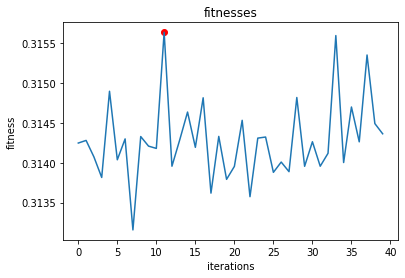

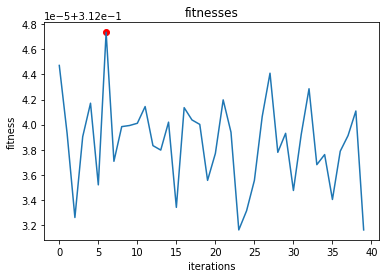

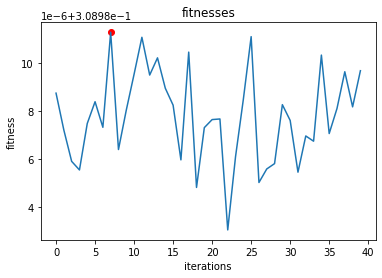

In [66]:
opt.plot_all()

#### 1D

In [64]:
num_one_gates = 3
num_two_gates = 1
max_moments = 3
n_qubits = 4

In [73]:
pop_size = 20

opt = CircuitOptimizer(pop_size, probability_pt, num_one_gates, num_two_gates, max_moments, n_qubits)

Execution time multiprocessing 147.6850140094757
Generation: 0 Fittest: 0.9642577460670907


In [78]:
opt.selection()

In [79]:
opt.crossover()

entering crossover
index 0
index 2


In [70]:
len(opt.parents)

5

In [43]:
opt.mutate()

Generation: 0 Fittest: 0.6236876348495684


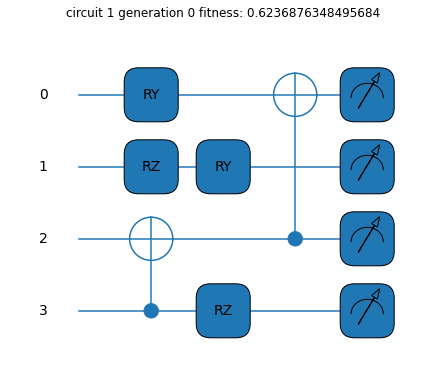

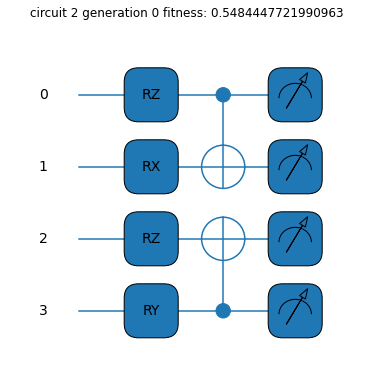

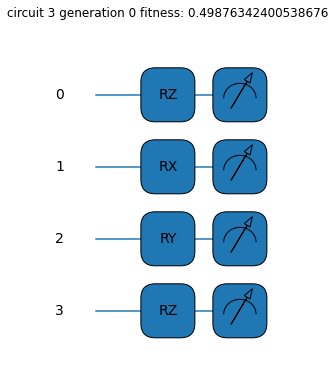

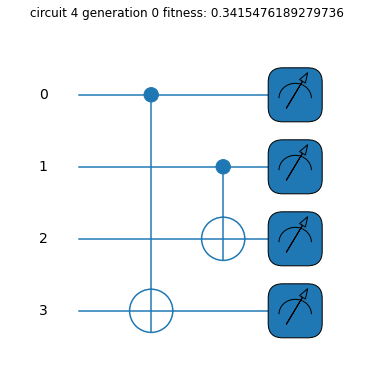

In [106]:
opt.draw_all_circuits()

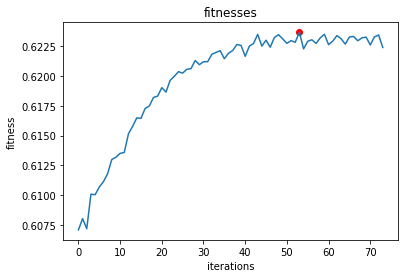

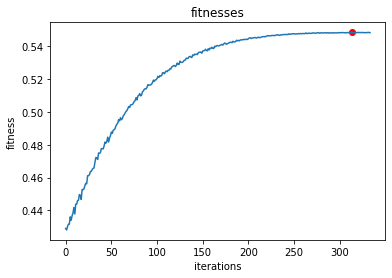

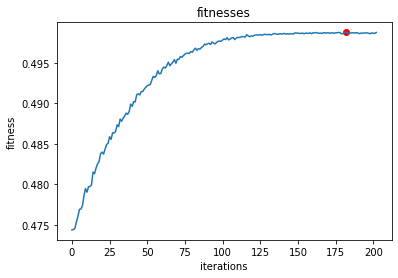

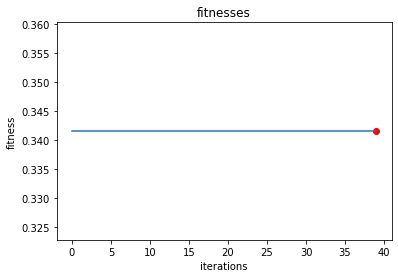

In [107]:
opt.plot_all()

In [126]:
opt.print_info()

Generation: 2 Fittest: 0.9629434170109116


In [110]:
opt.train_offsprings()

Execution time multiprocessing 211.95670700073242


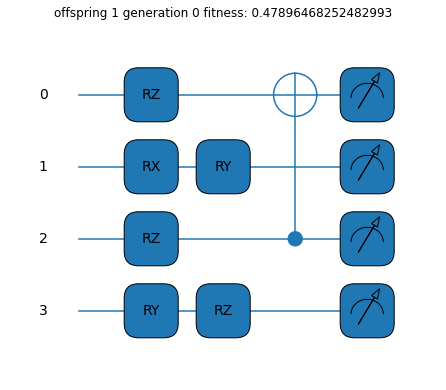

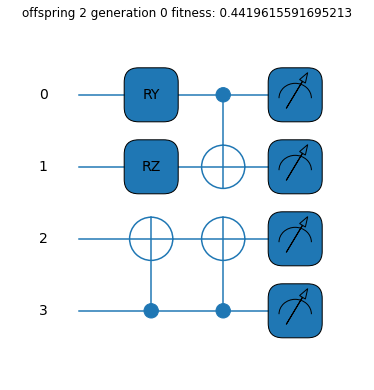

In [111]:
opt.draw_offsprings()

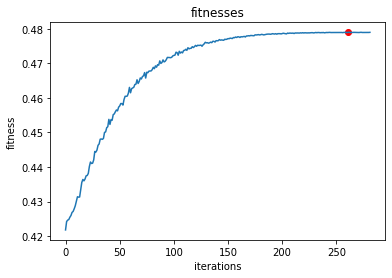

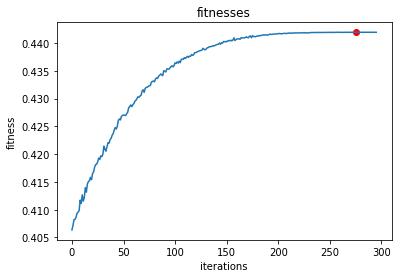

In [112]:
opt.plot_offsprings()

In [113]:
opt.add_offsprings()

Generation: 0 Fittest: 0.6236876348495684


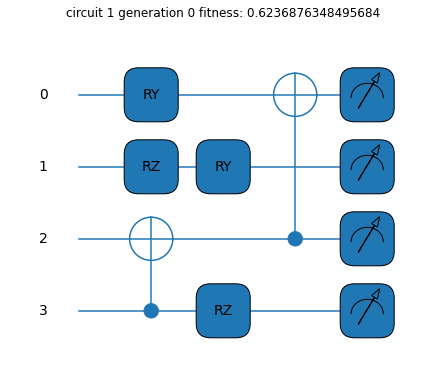

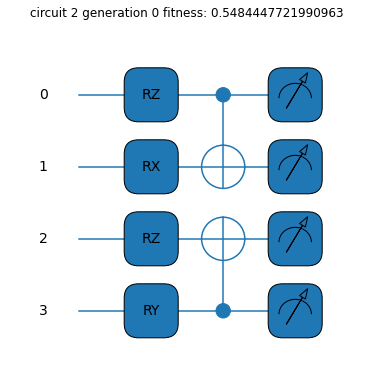

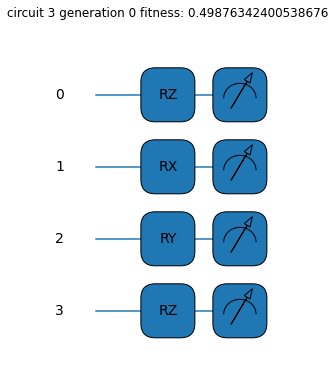

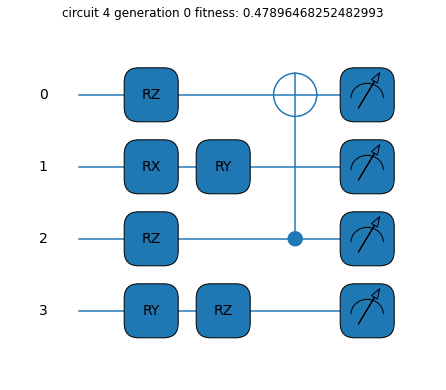

In [114]:
opt.draw_all_circuits()

#### Outer Loop

Execution time multiprocessing 84.64871907234192
Generation: 0 Fittest: 0.498735754187284
Execution time multiprocessing 10.374071598052979
Execution time multiprocessing 125.2265145778656
Execution time multiprocessing 130.53918957710266
Execution time multiprocessing 63.01316165924072
Execution time multiprocessing 12.410381317138672
Execution time multiprocessing 35.5837128162384


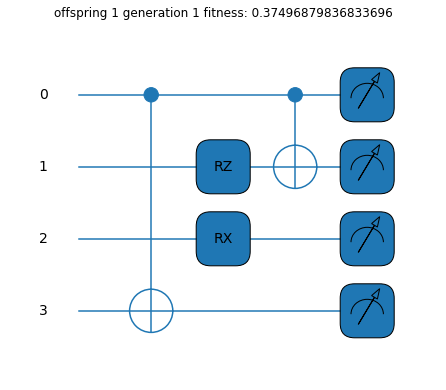

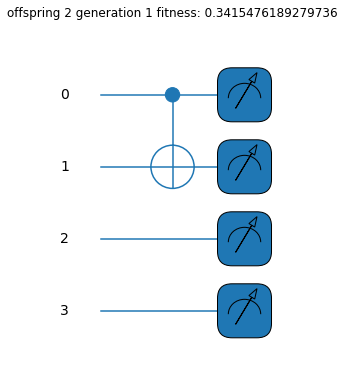

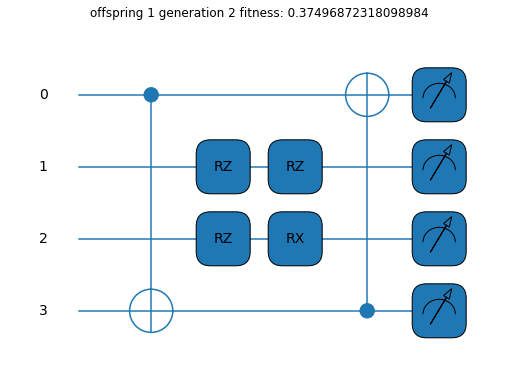

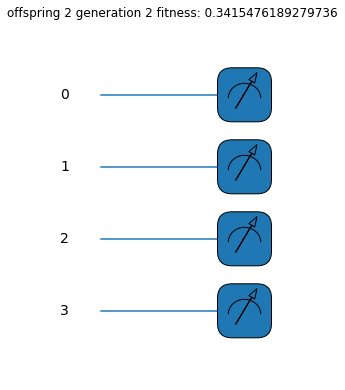

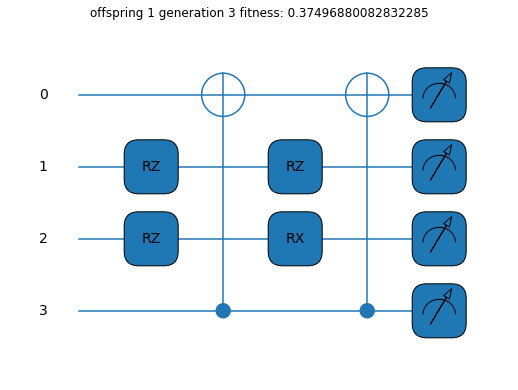

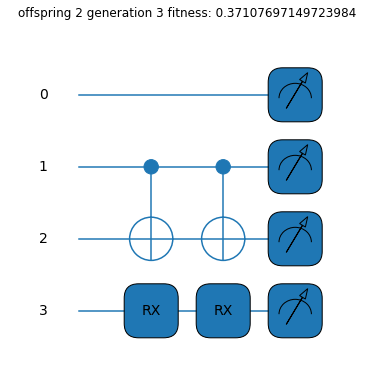

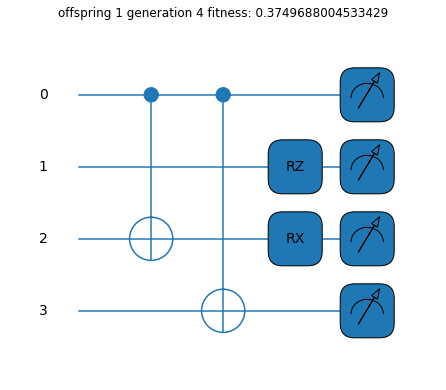

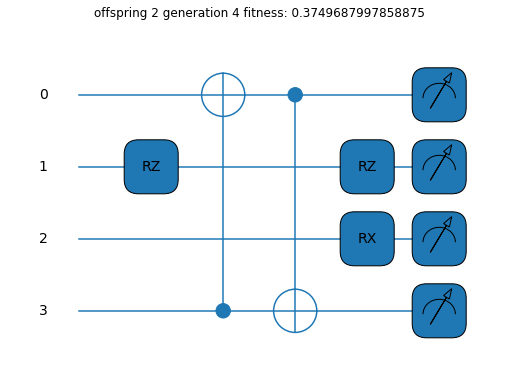

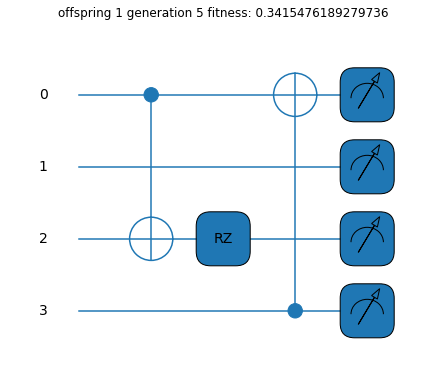

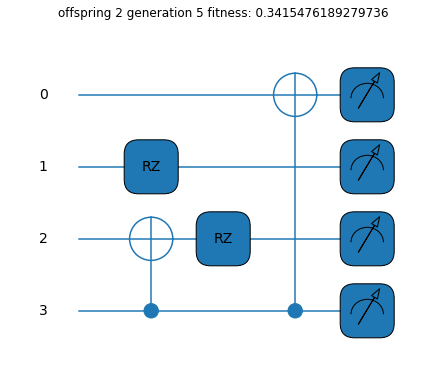

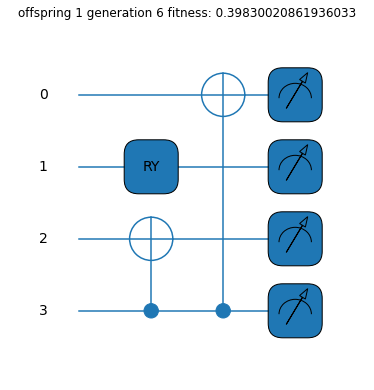

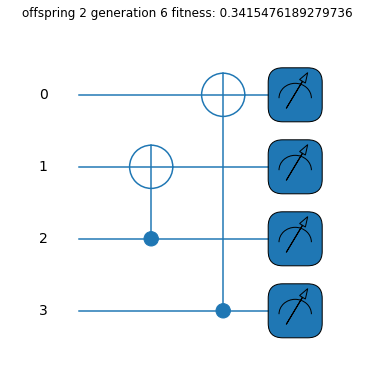

In [125]:
pop_size = 3
opt1 = CircuitOptimizer(pop_size, probability_pt, num_one_gates, num_two_gates, max_moments, n_qubits)
curr_max_fitness = opt1.population.fittest.get_fitness()
overall_max_fitness = curr_max_fitness
patience = 5

unchanged_num_gens = 0
while unchanged_num_gens <= patience:
    opt1.generation += 1
    opt1.selection()
    opt1.crossover()
    
    for i in range(3):
        if random.random() < 0.7:
            opt1.mutate()
            
    opt1.train_offsprings()
    opt1.draw_offsprings()

    opt1.add_offsprings()
    
    curr_max_fitness = opt1.population.fittest.get_fitness()
    if curr_max_fitness > overall_max_fitness:
        overall_max_fitness = curr_max_fitness
        unchanged_num_gens = 0
    else:
        unchanged_num_gens +=1

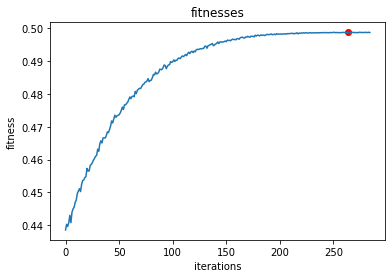

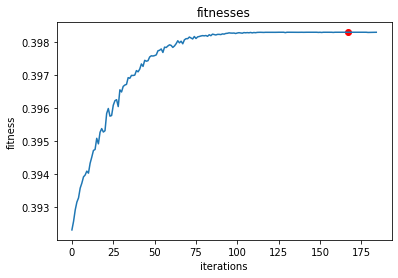

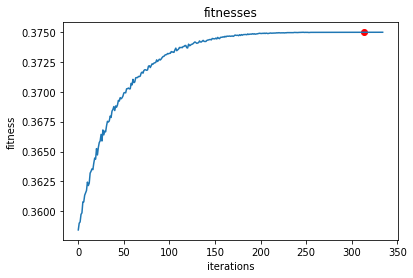

In [127]:
opt1.plot_all()

Execution time multiprocessing 25.456135988235474
Generation: 0 Fittest: 0.7668450945276359
generation 1
Execution time multiprocessing 46.09889030456543
Generation: 1 Fittest: 0.7693323595697199
generation 2
Execution time multiprocessing 35.850521087646484
Generation: 2 Fittest: 0.9629434170109116


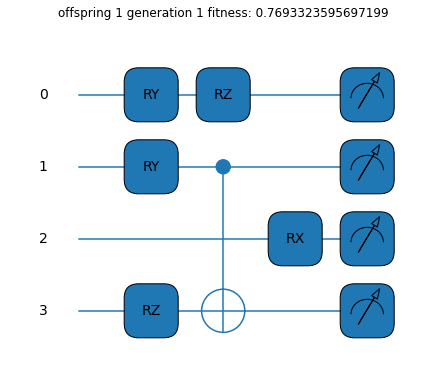

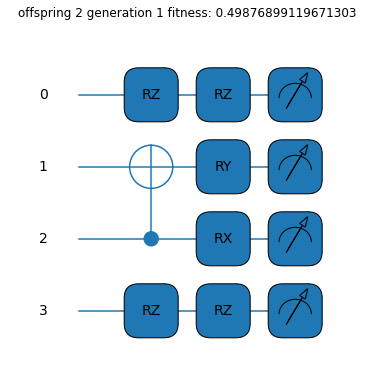

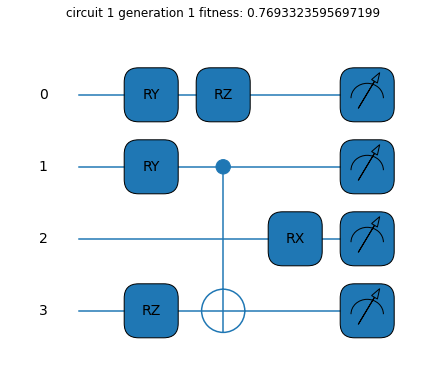

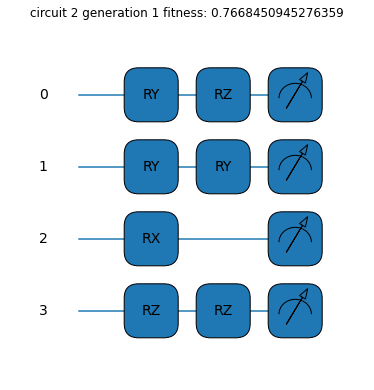

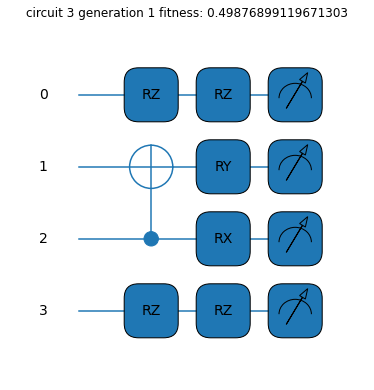

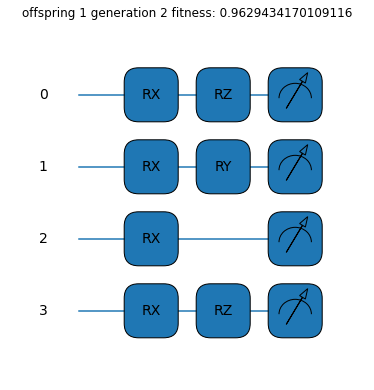

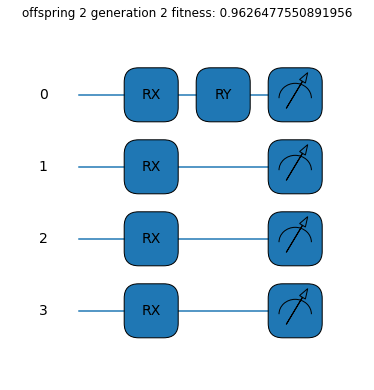

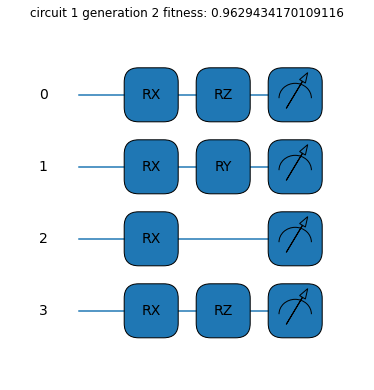

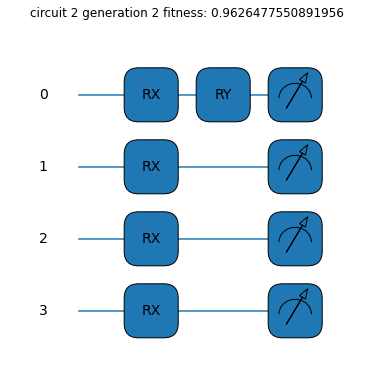

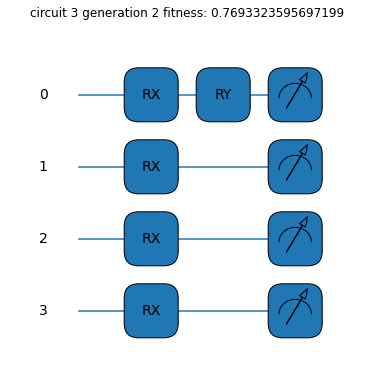

In [122]:
pop_size = 3
opt = CircuitOptimizer(pop_size, probability_pt, num_one_gates, num_two_gates, max_moments, n_qubits)
max_fitness = opt.population.fittest.get_fitness()
counter = 0
while max_fitness < 0.8:
    opt.generation += 1
    opt.selection()
    opt.crossover()
    
    counter += 1
    print("generation {}".format(counter))
    
    for i in range(3):
        if random.randint(0, 5) < 7:
            opt.mutate()
    
    opt.train_offsprings()
    opt.draw_offsprings()

    opt.add_offsprings()
    max_fitness = opt.population.fittest.get_fitness()
    opt.draw_all_circuits()

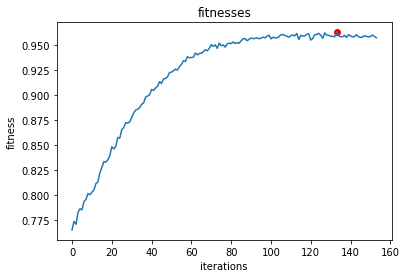

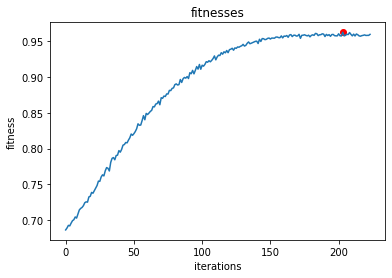

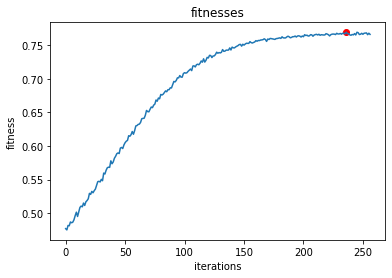

In [123]:
opt.plot_all()

Generation: 2 Fittest: 0.9629434170109116


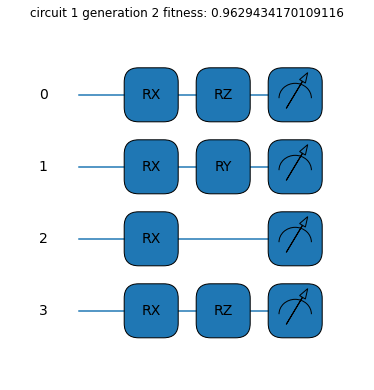

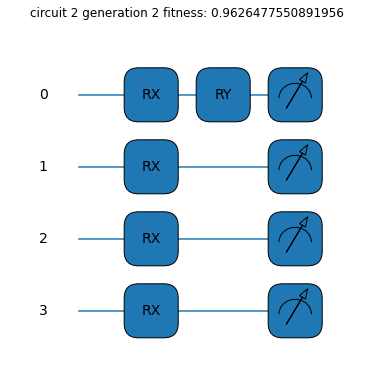

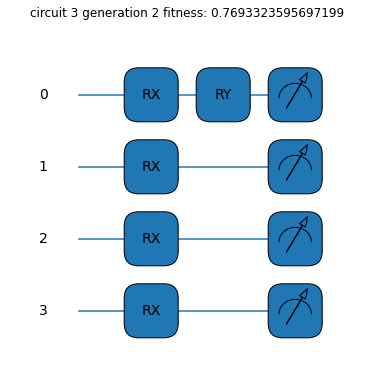

In [124]:
opt.draw_all_circuits()

In [119]:
for i in range(len(opt.population.individuals)):
    print(opt.population.individuals[i].get_fitness())

0.6673033546988425
0.5028872584080459
0.3415476189279736
